<a href="https://colab.research.google.com/github/Seghelicious/Cars45/blob/main/Cars45_Prediction_of_Best_Price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**

The goal of this assessment is to predict the best prices to buy cars from customers based on the data provided.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# **Importing Required Libraries**

In [ ]:
# Data Manipulation libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date

# Visualisation libraries
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import pyplot
from matplotlib import style
plt.style.use('ggplot')
import itertools
import warnings
warnings.filterwarnings('ignore')

# Missing Values Imputation libraries
from sklearn.neighbors import NearestNeighbors
from sklearn.impute import KNNImputer

# Preprocessing libraries
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# Model Development libraries
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score, train_test_split 
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Model Evaluation libraries
from sklearn.metrics import mean_squared_error

pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [ ]:
cars45 = pd.read_csv('/content/drive/My Drive/Cars45/Cars_Data_CSV.csv')
cars45.head()

,make,model,mileage,manufacture_year,engine_displacement,engine_power,body_type,color_slug,transmission,door_count,seat_count,fuel_type,date_created,price_NGN
0,audi,NaN,330000.00,1995,2600.00,110.00,compact,nan,auto,None,None,gasoline,2015-11-14 20:10:48.033192+00,873428
1,audi,200,nan,1995,nan,nan,compact,nan,NaN,None,None,gasoline,2015-11-14 20:11:19.607788+00,66616
2,audi,NaN,nan,1995,11199.00,nan,compact,nan,NaN,None,None,gasoline,2015-11-14 20:11:20.320579+00,66616
3,audi,NaN,nan,1995,nan,nan,compact,nan,NaN,None,None,gasoline,2015-11-14 20:11:21.801285+00,66604
4,audi,a6,347000.00,1995,nan,85.00,compact,nan,auto,None,None,gasoline,2015-11-14 20:12:41.082787+00,843820


In [ ]:
cars45.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 638562 entries, 0 to 638561
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   make                 638562 non-null  object 
 1   model                454990 non-null  object 
 2   mileage              603981 non-null  float64
 3   manufacture_year     638562 non-null  int64  
 4   engine_displacement  489134 non-null  float64
 5   engine_power         537375 non-null  float64
 6   body_type            72636 non-null   object 
 7   color_slug           0 non-null       float64
 8   transmission         541441 non-null  object 
 9   door_count           638562 non-null  object 
 10  seat_count           638562 non-null  object 
 11  fuel_type            638562 non-null  object 
 12  date_created         638562 non-null  object 
 13  price_NGN            638562 non-null  int64  
dtypes: float64(4), int64(2), object(8)
memory usage: 68.2+ MB


In [ ]:
cars45.shape

(638562, 14)

# **Data Cleaning**

I have split the date_created column into a date and time column. I have also changed the data types appropriately.

The data types of the manafacture_year and price_NGN columns have also been changed from float to integer.

In [ ]:
cars45['date_created'] = pd.to_datetime(cars45['date_created'])
cars45['date'] = cars45['date_created'].dt.strftime('%Y-%m-%d')
cars45['time'] = cars45['date_created'].dt.strftime('%H:%M')
cars45 = cars45.drop(columns = ['date_created'])
cars45 = cars45.drop(columns = ['color_slug'])

In [ ]:
cars45['manufacture_year'] = cars45['manufacture_year'].astype(int)
cars45['price_NGN'] = cars45['price_NGN'].astype(int)
cars45['door_count'] = cars45['door_count'].replace('None', '100')
cars45['door_count'] = cars45['door_count'].astype(int)
cars45['door_count'] = cars45['door_count'].replace(100, np.nan)
cars45['seat_count'] = cars45['seat_count'].replace('None', '100')
cars45['seat_count'] = cars45['seat_count'].astype(int)
cars45['seat_count'] = cars45['seat_count'].replace(100, np.nan)


# **Handling Extreme Values - Outliers**


In [ ]:
cars45.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
mileage,603981.00,115283.86,365012.42,0.00,22000.00,82500.00,150000.00,9999999.00
manufacture_year,638562.00,2008.72,5.50,1995.00,2005.00,2010.00,2014.00,2016.00
engine_displacement,489134.00,2100.23,1931.07,10.00,1461.00,1898.00,2143.00,32000.00
engine_power,537375.00,105.05,53.30,3.00,73.00,94.00,125.00,999.00
door_count,451206.00,3.68,0.84,1.00,4.00,4.00,4.00,6.00
seat_count,409865.00,4.87,0.86,1.00,5.00,5.00,5.00,74.00
price_NGN,638562.00,6171796.44,179858592.43,16.00,1600592.00,3980296.00,7377492.00,82310297260.00


Observations. 

- There is a noticeably large difference between the mean with the 50% and 75% percentiles for the mileage variable.
- There is a noticeable large difference between the 75th percentile and the maximum values of the mileage, engine_displacement, engine_power and price_NGN.
- There is also a noticeably large difference between the minimum values and the 25% percentile of the price_NGN variable.
- The standard deviation between the mileage, engine_displacement and price_NGN variables is noticeably high.

These observations suggest that there are outliers in our data.

### Fixing Extreme Values


#### Seat Count

In [ ]:
cars45['seat_count'].describe()

count   409865.00
mean         4.87
std          0.86
min          1.00
25%          5.00
50%          5.00
75%          5.00
max         74.00
Name: seat_count, dtype: float64

In [ ]:
cars45.loc[cars45['seat_count'] > 15, 'seat_count'] = np.nan

In [ ]:
cars45['seat_count'].describe()

count   409847.00
mean         4.87
std          0.84
min          1.00
25%          5.00
50%          5.00
75%          5.00
max         15.00
Name: seat_count, dtype: float64


#### Mileage

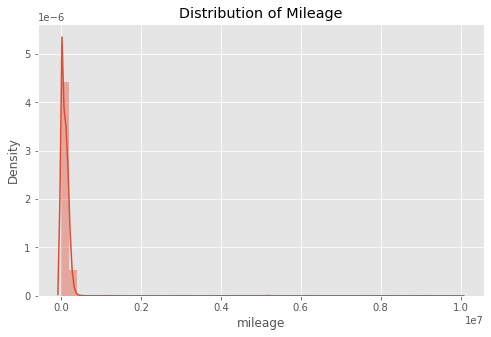

In [ ]:
plt.figure(figsize = (8, 5))
plt.title('Distribution of Mileage')
sns.distplot(cars45['mileage'])

The minimum value for mileage is 0. Brand new cars typically have a few hundred miles on their odometers. This is because the new cars are vigorously test-driven or moved from the assembly plant to storage or from the dealership to the client's location.

For this reason, I have pegged the floor and ceiling values at 100 and 200000 miles. Mileage values not in this range will be replaced with np.nan. 

In [ ]:
cars45.loc[cars45['mileage'] < 100, 'mileage'] = np.nan
cars45.loc[cars45['mileage'] > 200000, 'mileage'] = np.nan

In [ ]:
cars45['mileage'].describe()

count   482767.00
mean     84086.05
std      58825.21
min        100.00
25%      27580.50
50%      79850.00
75%     133000.00
max     200000.00
Name: mileage, dtype: float64

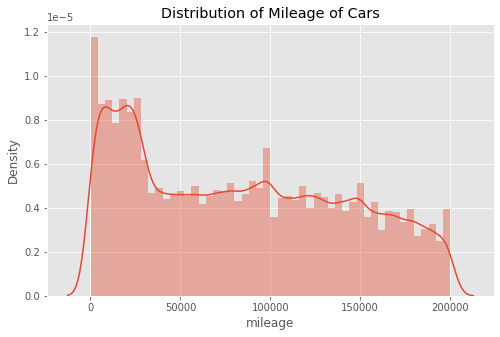

In [ ]:
plt.figure(figsize = (8, 5))
plt.title('Distribution of Mileage of Cars')
sns.distplot(cars45.query('mileage <= 200000')['mileage'])

We can see that the histogram for mileage is right-skewed, with 75% of cars having a mileage less than 130000 miles.

#### Engine Displacement

In [ ]:
cars45['engine_displacement'].describe()

count   489134.00
mean      2100.23
std       1931.07
min         10.00
25%       1461.00
50%       1898.00
75%       2143.00
max      32000.00
Name: engine_displacement, dtype: float64

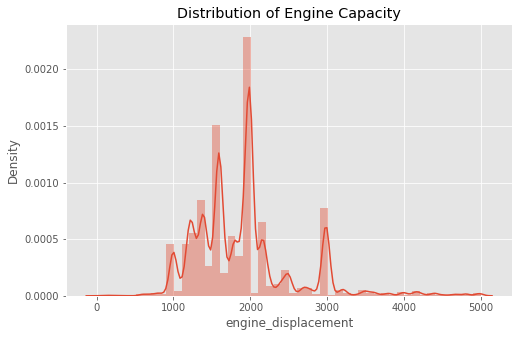

In [ ]:
plt.figure(figsize = (8, 5))
plt.title('Distribution of Engine Capacity')
sns.distplot(cars45.query('engine_displacement <= 5000')['engine_displacement'])

It can be observed that the minimum engine displacement value is about 10 cc which is about 10 cc (0.01 liters) and the maximum is 32000 cc (32 liters). This values are grossly unrealistic. According to Drive Spark (https://www.drivespark.com/four-wheelers/2016/five-smallest-displacement-engines-production-cars/articlecontent-pf50711-019057.html), the smallest car engine is the smart fortwo with 898 cc. 

The strategy for handling extreme values for engine_displacement shall be similar to that of mileage. The floor and ceiling values will be pegged between 1000 and 5000 cc.

So, like the mileage values, besides the smart fortwo, the range of values for the engine_displacement is between 1000 and 5000 cc, extreme values outside this range will be replaced with np.nan.

In [ ]:
cars45.loc[cars45['engine_displacement'] < 1000, 'engine_displacement'] = np.nan
cars45.loc[cars45['engine_displacement'] > 5000, 'engine_displacement'] = np.nan

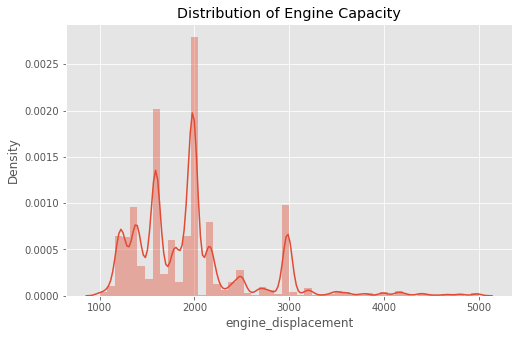

In [ ]:
plt.figure(figsize = (8, 5))
plt.title('Distribution of Engine Capacity')
sns.distplot(cars45['engine_displacement'])

#### Engine Power

In [ ]:
cars45['engine_power'].describe()

count   537375.00
mean       105.05
std         53.30
min          3.00
25%         73.00
50%         94.00
75%        125.00
max        999.00
Name: engine_power, dtype: float64

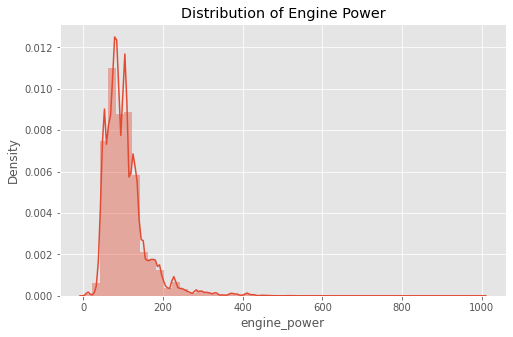

In [ ]:
plt.figure(figsize = (8, 5))
plt.title('Distribution of Engine Power')
sns.distplot(cars45['engine_power'])

An engine_power of 3 horsepower (hp) is both unrealistic and highly unlikely. According to Autoguide (https://www.autoguide.com/auto-news/2017/07/top-10-cars-with-the-least-horsepower-in-2017.html#:~:text=The%20least%20powerful%20car%20available,74%20lb%2Dft%20of%20torque.) puts the least engine power at 78hp.

As per the strategy for extreme values, I shall peg the floor - ceiling range between 100 and 400 hp.

In [ ]:
cars45.loc[cars45['engine_power'] < 100, 'engine_power'] = np.nan
cars45.loc[cars45['engine_power'] > 400, 'engine_power'] = np.nan

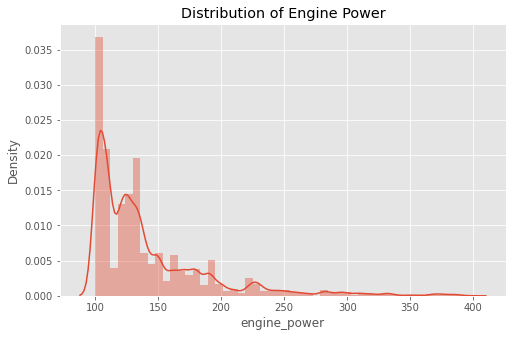

In [ ]:
plt.figure(figsize = (8, 5))
plt.title('Distribution of Engine Power')
sns.distplot(cars45.query('engine_power < 400')['engine_power'])

In [ ]:
cars45['engine_power'].describe()

count   253173.00
mean       141.32
std         48.36
min        100.00
25%        110.00
50%        125.00
75%        155.00
max        400.00
Name: engine_power, dtype: float64

#### Price

In [ ]:
cars45['price_NGN'].describe()

count        638562.00
mean        6171796.44
std       179858592.43
min              16.00
25%         1600592.00
50%         3980296.00
75%         7377492.00
max     82310297260.00
Name: price_NGN, dtype: float64

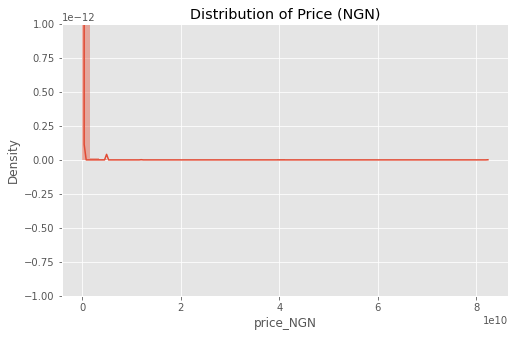

In [ ]:
plt.figure(figsize = (8, 5))
plt.title('Distribution of Price (NGN)')
sns.distplot(cars45['price_NGN'])

The price_NGN variable is riddled with extreme values, mostly unrealistic!
- The minimum price is 16 NGN.
- The standard deviation is 179 858 600 NGN.
- The 25th - 75th percentile values look fine (between 1,600,592 - 7,377,492 NGN)
- The maximum price is 82,310,300,000 NGN.



The price variable is the trickiest and also the most important variable in our data. My strategy for cleaning the price data is different from the rest. 

I have grouped the data into seperate dataframes by the make of the car, i.e. all audis in one dataframe, all jaguars in another, etc.

So I'll be looking at the price data by make.

In [ ]:
audi = cars45.loc[cars45['make'] == 'audi'].reset_index(drop = True)
bentley = cars45.loc[cars45['make'] == 'bentley'].reset_index(drop = True)
bmw = cars45.loc[cars45['make'] == 'bmw'].reset_index(drop = True)
chevrolet = cars45.loc[cars45['make'] == 'chevrolet'].reset_index(drop = True)
chrysler = cars45.loc[cars45['make'] == 'chrysler'].reset_index(drop = True)
citroen = cars45.loc[cars45['make'] == 'citroen'].reset_index(drop = True)
dodge = cars45.loc[cars45['make'] == 'dodge'].reset_index(drop = True)
fiat = cars45.loc[cars45['make'] == 'fiat'].reset_index(drop = True)
ford = cars45.loc[cars45['make'] == 'ford'].reset_index(drop = True)
honda = cars45.loc[cars45['make'] == 'honda'].reset_index(drop = True)
hyundai = cars45.loc[cars45['make'] == 'hyundai'].reset_index(drop = True)
isuzu = cars45.loc[cars45['make'] == 'isuzu'].reset_index(drop = True)
jaguar = cars45.loc[cars45['make'] == 'jaguar'].reset_index(drop = True)
jeep = cars45.loc[cars45['make'] == 'jeep'].reset_index(drop = True)
kia = cars45.loc[cars45['make'] == 'kia'].reset_index(drop = True)
lamborghini = cars45.loc[cars45['make'] == 'lamborghini'].reset_index(drop = True)
lancia = cars45.loc[cars45['make'] == 'lancia'].reset_index(drop = True)
maserati = cars45.loc[cars45['make'] == 'maserati'].reset_index(drop = True)
mazda = cars45.loc[cars45['make'] == 'mazda'].reset_index(drop = True)
mercedes = cars45.loc[cars45['make'] == 'mercedes-benz'].reset_index(drop = True)
mini = cars45.loc[cars45['make'] == 'mini'].reset_index(drop = True)
mitsubishi = cars45.loc[cars45['make'] == 'mitsubishi'].reset_index(drop = True)
nissan = cars45.loc[cars45['make'] == 'nissan'].reset_index(drop = True)
opel = cars45.loc[cars45['make'] == 'opel'].reset_index(drop = True)
porsche = cars45.loc[cars45['make'] == 'porsche'].reset_index(drop = True)
rover = cars45.loc[cars45['make'] == 'rover'].reset_index(drop = True)
seat = cars45.loc[cars45['make'] == 'seat'].reset_index(drop = True)
skoda = cars45.loc[cars45['make'] == 'skoda'].reset_index(drop = True)
subaru = cars45.loc[cars45['make'] == 'subaru'].reset_index(drop = True)
suzuki = cars45.loc[cars45['make'] == 'suzuki'].reset_index(drop = True)
toyota = cars45.loc[cars45['make'] == 'toyota'].reset_index(drop = True)
volvo = cars45.loc[cars45['make'] == 'volvo'].reset_index(drop = True)
hummer = cars45.loc[cars45['make'] == 'hummer'].reset_index(drop = True)
lexus = cars45.loc[cars45['make'] == 'lexus'].reset_index(drop = True)
tesla = cars45.loc[cars45['make'] == 'tesla'].reset_index(drop = True)
lotus = cars45.loc[cars45['make'] == 'lotus'].reset_index(drop = True)
smart = cars45.loc[cars45['make'] == 'smart'].reset_index(drop = True)

##### Audi

In [ ]:
audi['price_NGN'].describe()

count         72529.00
mean        8329650.78
std       148648557.41
min              16.00
25%         3300488.00
50%         6891412.00
75%        10460356.00
max     40004440756.00
Name: price_NGN, dtype: float64

There are some extreme values in the audi prices.
The minimum price is 16 NGN and the maximum price is over 40 billion NGN.
There is a noticeably large difference between the prices in the 75% percentile and the maximum price. 

In [ ]:
audi.groupby('model').agg({'price_NGN': ['min', 'max']})

price_NGN           
                 min        max
model                          
100            22204   33304928
200               16   36861584
80                88   60176904
90            281272   43672052
a1           2761020   48055516
a2            340192   10000712
a3                16   22002444
a4                16  164487208
a4-allroad    503332   19924100
a5             14788   25183732
a6                16  444608884
a6-allroad        16   69563288
a7               120   35799972
a8                16   70548440
coupe             16   56016580
q3             44012   24185700
q5             29608   39605864
q7             22204   36994820
r8           3762088   78008660
rs2          4762648   20002560
rs3          6203448   28637988
rs4           839912   43612908
rs5           460132   29170792
rs6             1644   56310732
rs7         26495500   48672804
s3             10364   25047416
s4            207252   22833736
s5           5960888   27054404
s6           1000076   31211548
s7          15091428   29176432
s8            962252   52306336
sq5          8396936   31163464
tt               148   47042604
v8           1320148   13201376

I have grouped the data by minimum and maximum prices in each model category. A lot of the outliers have been exposed. The minimum values by model hold a lot of unrealistic values.

I took a look at the prices of Audi cars on the cars45 site (https://buy.cars45.com/cars&filter=2), the cheapest audi car is the 1999 Audi A4 (Mileage: 247,353km) at a price of 304,000 NGN.

Based on this I set the floor of the Audi car prices to 300,000 NGN.
The 75% percentile price is at 10,460,356 NGN. So based on this I set the floor of the Audi cars to 15,000,000 NGN. Any price that falls outside this floor - ceiling range is replaced with np.nan

In [ ]:
audi.loc[audi['price_NGN'] < 300000, 'price_NGN'] = np.nan
audi.loc[audi['price_NGN'] > 15000000, 'price_NGN'] = np.nan

In [ ]:
audi['price_NGN'].describe()

count      64827.00
mean     6480795.98
std      3864013.22
min       300016.00
25%      3080460.00
50%      6380948.00
75%      9409654.00
max     14999852.00
Name: price_NGN, dtype: float64

##### Bentley

In [ ]:
bentley['price_NGN'].describe()

count         273.00
mean     47132871.43
std      24747424.98
min       3800564.00
25%      25122784.00
50%      47649132.00
75%      63967104.00
max     127126412.00
Name: price_NGN, dtype: float64

In [ ]:
bentley.groupby('model').agg({'price_NGN': ['min', 'max']})

price_NGN          
                              min       max
model                                      
arnage                    6602444  32013768
brooklands                3800564   7901168
continental-flying-spur  13206928  69217692
continental-gt           13021924  81550568
continental-gtc          22863568  86031548
continental-r            15234256  36802724
continental-t            50027756  50027756
turbo-r                  32404796  32404796

It is observed that the Bentley is a luxury car. The minimum Bentley pricing across all models ranges from 3.8 million NGN to 50 million NGN and the maximum pricing ranges from 7.9 million NGN to 86 million NGN. 

Leading with this, the floor - ceiling prices for the bentley will be pegged from 3.5 million NGN to 90 million NGN.

In [ ]:
bentley.loc[bentley['price_NGN'] < 3500000, 'price_NGN'] = np.nan
bentley.loc[bentley['price_NGN'] > 90000000, 'price_NGN'] = np.nan

In [ ]:
bentley['price_NGN'].describe()

count        262.00
mean    44558340.53
std     21606597.22
min      3800564.00
25%     24401808.00
50%     45941294.00
75%     62121447.00
max     86050376.00
Name: price_NGN, dtype: float64

##### BMW

In [ ]:
bmw['price_NGN'].describe()

count         78587.00
mean        7706573.99
std        45545072.06
min              16.00
25%         3101716.00
50%         6382592.00
75%        10316234.00
max     12001332348.00
Name: price_NGN, dtype: float64

There are certainly some extremely priced BMWs. 
The standard deviation is more than the mean and more than the 75th percentile price. And the minimum price for BMWs is 16 NGN and the maximum price is 12 billion NGN!

In [ ]:
bmw.groupby('model').agg({'price_NGN': ['min', 'max']})

price_NGN           
             min        max
model                      
alpina    799628  148021908
i3       5003080   20208408
i8      36640076   62027536
m3            16   67967548
m4            16   38813236
m5          1464   40869652
m6        840472   50293044
x1          7400   83986308
x3           488  117977468
x4        614360   30092244
x5            16   49007252
x6          3048   47997780
z3         44412   15982368
z4         29608   27651992
z8      55988292  146021612

Leading with the pricing aggregates in the table above, the floor - ceiling pricing is pegged between 600,000 NGN and 147,000,000 NGN.

In [ ]:
bmw.loc[bmw['price_NGN'] < 600000, 'price_NGN'] = np.nan
bmw.loc[bmw['price_NGN'] > 147000000, 'price_NGN'] = np.nan

In [ ]:
bmw['price_NGN'].describe()

count       75846.00
mean      7747747.70
std       5980615.84
min        600028.00
25%       3401260.00
50%       6672896.00
75%      10418352.00
max     146021612.00
Name: price_NGN, dtype: float64

##### Chevrolet

In [ ]:
chevrolet['price_NGN'].describe()

count       4179.00
mean     3490246.78
std      4181831.72
min           16.00
25%      1200532.00
50%      2305936.00
75%      4240326.00
max     39974788.00
Name: price_NGN, dtype: float64

In [ ]:
chevrolet.groupby('model').agg({'price_NGN': ['min', 'max']})

price_NGN          
                  min       max
model                          
alero          399704    814212
astro-van     3241436   5180384
avalanche     1400208  11803244
aveo            51812   5196580
blazer             64   5000564
camaro         185048  39974788
caprice       3601200   3601200
captiva            16  10761200
cobalt        3390080   3390080
colorado      3440504  18208720
corvette       147892  35482620
cruze           29652   7198136
epica          962252   3140120
evanda         325684   1760784
hhr           1699792   3441524
impala        3026144  17966648
lacetti        429312   3120460
lumina         399628    399628
malibu        2900104   9765420
matiz          147892   2372348
niva          1400208   1400208
nubira             16   2980224
orlando       2463716   6998592
s10            500280    889060
silverado     2800828  31971828
spark              16   4280312
suburban      1332348  34048112
tacuma            504   1560756
tahoe         1560872  32772124
tracker        556076    556076
trailblazer        16   5996892
trans-sport    200120   1761660
trax          4402604  10280756
venture        888232    888232

Leading with the pricing aggregates in the table above, the floor - ceiling pricing is pegged between 325,000 NGN and 12,000,000 NGN.

In [ ]:
chevrolet.loc[chevrolet['price_NGN'] < 325000, 'price_NGN'] = np.nan
chevrolet.loc[chevrolet['price_NGN'] > 40000000, 'price_NGN'] = np.nan

In [ ]:
chevrolet['price_NGN'].describe()

count       4147.00
mean     3516294.95
std      4187357.40
min       325684.00
25%      1280088.00
50%      2306276.00
75%      4286854.00
max     39974788.00
Name: price_NGN, dtype: float64

##### Chrysler

In [ ]:
chrysler['price_NGN'].describe()

count       2145.00
mean     2061694.88
std      2167667.23
min           16.00
25%       760060.00
50%      1316064.00
75%      2600296.00
max     27533680.00
Name: price_NGN, dtype: float64

In [ ]:
chrysler.groupby('model').agg({'price_NGN': ['min', 'max']})

price_NGN          
                    min       max
model                            
200              962252  17098432
300c                 16  11056004
300m                 16   1100120
concorde         518120    518120
crossfire       1702444  11158608
es               220016   7963836
grand-voyager    140636  13413088
gts            15800340  15800340
neon              29680   1100120
new-yorker       580280   2220576
pacifica        1472540   3894300
pt-cruiser       196064   3961168
sebring              28   5961760
stratus           72540   2361140
town-country     740192  11464100
vision           240028   1980224
voyager              16  11077248

Leading with the pricing aggregates in the table above, the floor - ceiling pricing is pegged between 200,000 NGN and 20,000,000 NGN.

In [ ]:
chrysler.loc[chrysler['price_NGN'] < 200000, 'price_NGN'] = np.nan
chrysler.loc[chrysler['price_NGN'] > 20000000, 'price_NGN'] = np.nan

In [ ]:
chrysler['price_NGN'].describe()

count       2116.00
mean     2064694.30
std      2044972.51
min       200028.00
25%       780120.00
50%      1320436.00
75%      2620480.00
max     17098432.00
Name: price_NGN, dtype: float64

##### Citroen

In [ ]:
citroen['price_NGN'].describe()

count        27839.00
mean       4239340.94
std       65340203.39
min             16.00
25%        1280148.00
50%        3346380.00
75%        5601976.00
max     7698179244.00
Name: price_NGN, dtype: float64

In [ ]:
citroen.groupby('model').agg({'price_NGN': ['min', 'max']})

price_NGN            
                    min         max
model                              
ax                14804     2669592
berlingo             16   295514464
c-crosser       1924500     8800888
c-elysee        2649888     4825168
c1                54776     5600428
c2               200016    10066616
c3                   16     6402680
c3-picasso        81420     7200668
c4                   16    14801792
c4-aircross     4706544    11970288
c4-cactus       5091044     5847520
c4-picasso        29608    11599436
c5                   16    14803836
c6              1240768    12602992
c8                   16     8404664
ds3               11844    46393784
ds4             2442636    12270156
ds5             2361124    14957660
evasion              16     1520904
jumper               16    12337364
jumpy                16    17483360
nemo             207252     4397304
saxo                 16     2599880
xantia               16     2000592
xm                   44     2080236
xsara                16     2779540
xsara-picasso        16  7698179244
zx                   20      460268

Leading with the pricing aggregates in the table above, the floor - ceiling pricing is pegged between 350,000 NGN and 20,000,000 NGN.

In [ ]:
citroen.loc[citroen['price_NGN'] < 350000, 'price_NGN'] = np.nan
citroen.loc[citroen['price_NGN'] > 20000000, 'price_NGN'] = np.nan

In [ ]:
citroen['price_NGN'].describe()

count      26557.00
mean     3818325.86
std      2554991.64
min       350112.00
25%      1465580.00
50%      3560132.00
75%      5683152.00
max     17483360.00
Name: price_NGN, dtype: float64

##### Dodge

In [ ]:
dodge['price_NGN'].describe()

count       1094.00
mean    10225288.37
std      9967345.15
min         1480.00
25%      3003438.00
50%      5562264.00
75%     14791399.00
max     55620576.00
Name: price_NGN, dtype: float64

In [ ]:
dodge.groupby('model').agg({'price_NGN': ['min', 'max']})

price_NGN          
                    min       max
model                            
avenger         1613620   5203080
caliber         1160340   4396656
caravan           14804   5043492
charger         2339008  41975528
dakota          1340800   5101896
durango         1200668  27970348
grand-caravan    518136   9815960
intrepid           1480   1021464
journey         2000488   6758992
magnum          2000192  10205668
nitro           2664692   7962944
ram               73872  29974420
ram-1500         370080  29574228
sx               162696  10681968
viper           9602844  55620576

Leading with the pricing aggregates in the table above, the floor - ceiling pricing is pegged between 900,000 NGN and 60,000,000 NGN.

In [ ]:
dodge.loc[dodge['price_NGN'] < 900000, 'price_NGN'] = np.nan
dodge.loc[dodge['price_NGN'] > 60000000, 'price_NGN'] = np.nan

In [ ]:
dodge['price_NGN'].describe()

count       1070.00
mean    10445922.37
std      9967752.34
min       900268.00
25%      3156240.00
50%      5798534.00
75%     15001806.00
max     55620576.00
Name: price_NGN, dtype: float64

##### Fiat

In [ ]:
fiat['price_NGN'].describe()

count      33038.00
mean     2943399.47
std      2248672.48
min           16.00
25%      1076312.00
50%      2662102.00
75%      4199024.00
max     57130332.00
Name: price_NGN, dtype: float64

In [ ]:
fiat.groupby('model').agg({'price_NGN': ['min', 'max']})

price_NGN          
                   min       max
model                           
126              74020   1997188
500               5180  31915160
500l           2796108   8764872
500x           1200088  12804736
600             279616   2761020
barchetta        29608   3402012
brava               16   1672836
bravo               16  17024428
cinquecento      28008   3739808
coupe             7400   4361612
croma               16   4796536
doblo               16  14803836
freemont       2404084  57130332
grande-punto      2960   8660252
idea            276152   4198668
linea            29608   2360872
marea               16   1400428
multipla            16   4760712
palio               16   2956476
panda               60  40002560
punto               16   5402000
punto-evo       380148   7197068
qubo           1400104   7920592
regata           59200     59200
ritmo           296064    488528
sedici          962252   6603908
seicento            16   1800208
stilo               16   2596964
tempra          222044    889192
tipo           4098860   6410716
ulysse           14804   4321272
uno             240132    240132

Leading with the pricing aggregates in the table above, the floor - ceiling pricing is pegged between 900,000 NGN and 60,000,000 NGN.

In [ ]:
fiat.loc[fiat['price_NGN'] < 400000, 'price_NGN'] = np.nan
fiat.loc[fiat['price_NGN'] > 60000000, 'price_NGN'] = np.nan

In [ ]:
fiat['price_NGN'].describe()

count      30068.00
mean     3209396.31
std      2183490.34
min       400016.00
25%      1465580.00
50%      2916416.00
75%      4380488.00
max     57130332.00
Name: price_NGN, dtype: float64

##### Ford

In [ ]:
ford['price_NGN'].describe()

count         56844.00
mean        4690804.04
std        75425709.97
min              16.00
25%          980104.00
50%         2600384.00
75%         5082444.00
max     10917493588.00
Name: price_NGN, dtype: float64

In [ ]:
ford.groupby('model').agg({'price_NGN': ['min', 'max']})

price_NGN             
                      min          max
model                                 
b-max             2622592     32802176
c-max                  16     14803836
capri              140016       540164
connect              7388      8237216
cougar                 16      2760416
crown-victoria      22204      9963688
edge                29732     19665464
escape            1139896      5356196
escort                 16    295366396
excursion         5181540     13207328
expedition         760088      4202340
explorer               44     24369016
f-150            10747580     25973352
fiesta                 16    316053544
focus                  16  10917493588
freestar          5955424      5955424
fusion                 20      4380488
galaxy                 16     16346868
grand-c-max       2220576     10802400
gt                 240016    147610924
ka                     16   4938636728
kuga                23688    400236460
maverick               64      3801420
mondeo                 16   4737409432
mustang                16    400177248
probe               14804      2201228
puma                 1480      1599836
s-max                  16     16766824
scorpio              1480      1596656
sierra             800060       800060
streetka           320044      2300680
taunus             399704       399704
taurus              74020      1596240
thunderbird       1184308      5041600
tourneo-connect    480016     41499140
tourneo-courier   3688704      6740992
tourneo-custom    5602280     16998284
transit                16    296254804
windstar               16      2760312

Leading with the pricing aggregates in the table above, the floor - ceiling pricing is pegged between 400,000 NGN and 40,000,000 NGN.

In [ ]:
ford.loc[ford['price_NGN'] < 400000, 'price_NGN'] = np.nan
ford.loc[ford['price_NGN'] > 40000000, 'price_NGN'] = np.nan

In [ ]:
ford['price_NGN'].describe()

count      51290.00
mean     3743853.25
std      3030411.91
min       400016.00
25%      1316728.00
50%      3000444.00
75%      5377780.00
max     37974048.00
Name: price_NGN, dtype: float64

##### Honda

In [ ]:
honda['price_NGN'].describe()

count          5613.00
mean       24737262.24
std       924783019.56
min              16.00
25%         1140340.00
50%         2720208.00
75%         5025492.00
max     40023685760.00
Name: price_NGN, dtype: float64

In [ ]:
honda.groupby('model').agg({'price_NGN': ['min', 'max']})

price_NGN             
                min          max
model                           
accord           28     14362132
city          29712      7661244
civic            16  40023685760
cr-v          29608     15166736
cr-z        2797928      5562680
element          36       738712
fr-v        1120164      6196920
hr-v           2960     10122872
insight     2119912      5511060
integra      520044      4001080
jazz          29728      7389488
legend          132      8000784
nsx        16809328     39964440
odyssey      399704     12583272
pilot       2515172     17098432
prelude      200016      3801124
ridgeline   6362352      7604500
s2000       3801124      7989180
shuttle      320120      2796832
stream           28      2596772

Leading with the pricing aggregates in the table above, the floor - ceiling pricing is pegged between 400,000 NGN and 20,000,000 NGN.

In [ ]:
honda.loc[honda['price_NGN'] < 400000, 'price_NGN'] = np.nan
honda.loc[honda['price_NGN'] > 40000000, 'price_NGN'] = np.nan

In [ ]:
honda['price_NGN'].describe()

count       5161.00
mean     3625795.84
std      2750999.63
min       400016.00
25%      1400208.00
50%      2980324.00
75%      5200768.00
max     39964440.00
Name: price_NGN, dtype: float64

##### Hyundai

In [ ]:
hyundai['price_NGN'].describe()

count      14202.00
mean     4028466.82
std      3023462.86
min           16.00
25%      1599836.00
50%      3523774.00
75%      5708336.00
max     88026056.00
Name: price_NGN, dtype: float64

In [ ]:
hyundai.groupby('model').agg({'price_NGN': ['min', 'max']})

price_NGN          
               min       max
model                       
accent          20   2120312
coupe         4440   7180532
elantra         28   4441156
galloper    444116   2800844
genesis         28  24801836
getz            16   6201836
grandeur   1560060   4201244
i10            148   5580828
i20         444116   7240532
i30           2960  10397544
i40        1480384  14461064
ix20         26648   8220608
ix35         29592  12660932
ix55       3403404   8580312
lantra          16    780088
matrix          24  88026056
pony        200016    340044
santa-fe        16  19318312
santamo     239688    880268
sonata       14804  14803848
terracan        16   4596508
trajet       17764   3798104
veloster   2396712   8964528
xg          133236   1799868

Leading with the pricing aggregates in the table above, the floor - ceiling pricing is pegged between 400,000 NGN and 20,000,000 NGN.

In [ ]:
hyundai.loc[hyundai['price_NGN'] < 400000, 'price_NGN'] = np.nan
hyundai.loc[hyundai['price_NGN'] > 20000000, 'price_NGN'] = np.nan

In [ ]:
hyundai['price_NGN'].describe()

count      13582.00
mean     4191286.87
std      2876402.83
min       400028.00
25%      1909696.00
50%      3682844.00
75%      5811210.00
max     19493840.00
Name: price_NGN, dtype: float64

##### Isuzu

In [ ]:
isuzu['price_NGN'].describe()

count        388.00
mean     8326945.18
std      3090141.12
min        29532.00
25%      6993387.00
50%      8655366.00
75%      9983936.00
max     25002784.00
Name: price_NGN, dtype: float64

In [ ]:
isuzu.groupby('model').agg({'price_NGN': ['min', 'max']})

price_NGN          
              min       max
model                      
d-max     3082916  25002784
trooper    500044   2761020

Leading with the pricing aggregates in the table above, the floor - ceiling pricing is pegged between 500,000 NGN and 25,000,000 NGN.

In [ ]:
isuzu.loc[isuzu['price_NGN'] < 400000, 'price_NGN'] = np.nan
isuzu.loc[isuzu['price_NGN'] > 20000000, 'price_NGN'] = np.nan

In [ ]:
isuzu['price_NGN'].describe()

count        382.00
mean     8329632.93
std      2769086.88
min       500044.00
25%      7268594.00
50%      8694810.00
75%      9983659.00
max     18724768.00
Name: price_NGN, dtype: float64

##### Jaguar

In [ ]:
jaguar['price_NGN'].describe()

count        2014.00
mean     10328074.57
std      10176385.28
min            16.00
25%       2801178.00
50%       7997632.00
75%      14169886.00
max     180013324.00
Name: price_NGN, dtype: float64

In [ ]:
jaguar.groupby('model').agg({'price_NGN': ['min', 'max']})

price_NGN           
              min        max
model                       
daimler   2720904   17961332
f-type   17415160   66135172
s-type      40000    7953176
x-type     429312    7563360
xf        2220576   36021316
xj             16  180013324
xj6        725388   15961776
xj8        480164    8373236
xjr       1560576   11406336
xjs       7922340   11400844
xk        2601452   25018504
xk8       2599792  159623628
xkr       3397260   33613736

Leading with the pricing aggregates in the table above, the floor - ceiling pricing is pegged between 2,700,000 NGN and 180,000,000 NGN.

In [ ]:
jaguar.loc[jaguar['price_NGN'] < 2700000, 'price_NGN'] = np.nan
jaguar.loc[jaguar['price_NGN'] > 180000000, 'price_NGN'] = np.nan

In [ ]:
jaguar['price_NGN'].describe()

count        1545.00
mean     12881209.03
std       9290874.59
min       2716804.00
25%       6222696.00
50%      11564280.00
75%      15961776.00
max     159623628.00
Name: price_NGN, dtype: float64

##### Jeep

In [ ]:
jeep['price_NGN'].describe()

count       3943.00
mean     8653191.77
std      5261599.76
min         1480.00
25%      4399348.00
50%      8034788.00
75%     11970748.00
max     35202604.00
Name: price_NGN, dtype: float64

In [ ]:
jeep.groupby('model').agg({'price_NGN': ['min', 'max']})

price_NGN          
                     min       max
model                             
cherokee            3212  23805372
commander        3397260   9161360
compass          2205772   9841464
grand-cherokee      1480  33050984
liberty          1628424   9201020
patriot          1720104   6793012
renegade           98684  14205256
wrangler           51812  35202604

Leading with the pricing aggregates in the table above, the floor - ceiling pricing is pegged between 1,600,000 NGN and 36,000,000 NGN.

In [ ]:
jeep.loc[jeep['price_NGN'] < 1600000, 'price_NGN'] = np.nan
jeep.loc[jeep['price_NGN'] > 36000000, 'price_NGN'] = np.nan

In [ ]:
jeep['price_NGN'].describe()

count       3687.00
mean     9179201.28
std      5033451.97
min      1600120.00
25%      5689964.00
50%      8402796.00
75%     12361606.00
max     35202604.00
Name: price_NGN, dtype: float64

##### Kia

In [ ]:
kia['price_NGN'].describe()

count      10740.00
mean     4254347.97
std      2971441.17
min           16.00
25%      1900208.00
50%      3700964.00
75%      6216120.00
max     19960740.00
Name: price_NGN, dtype: float64

In [ ]:
kia.groupby('model').agg({'price_NGN': ['min', 'max']})

price_NGN          
               min       max
model                       
carens       74020  10956416
carnival        16  18702768
cerato          16   2360356
clarus      148040   1080164
joice        14804    720076
magentis      1480   3921600
opirus      738712   5181924
optima     2480372  14342784
picanto         16   5997292
pride        60028    718340
retona      296076   1280712
rio             16   7848348
sephia       11844    759688
shuma        29608   1596240
sorento         36  19960740
soul       1440060  11842768
sportage        16  15161688
venga      1450776   8600964

Leading with the pricing aggregates in the table above, the floor - ceiling pricing is pegged between 296,000 NGN and 20,000,000 NGN.

In [ ]:
kia.loc[kia['price_NGN'] < 296000, 'price_NGN'] = np.nan
kia.loc[kia['price_NGN'] > 20000000, 'price_NGN'] = np.nan

In [ ]:
kia['price_NGN'].describe()

count      10512.00
mean     4343839.65
std      2939977.66
min       296076.00
25%      1992584.00
50%      3839806.00
75%      6299199.00
max     19960740.00
Name: price_NGN, dtype: float64

##### Lamborghini

In [ ]:
lamborghini['price_NGN'].describe()

count          175.00
mean      88947573.42
std      302258101.42
min       10005552.00
25%       32017764.00
50%       47547832.00
75%       83690600.00
max     3992443228.00
Name: price_NGN, dtype: float64

In [ ]:
lamborghini.groupby('model').agg({'price_NGN': ['min', 'max']})

price_NGN           
                min        max
model                         
aventador  88003256  275661008
gallardo   22523300  100055516

Leading with the pricing aggregates in the table above, the floor - ceiling pricing is pegged between 25,000,000 NGN and 280,000,000 NGN.

In [ ]:
lamborghini.loc[lamborghini['price_NGN'] < 25000000, 'price_NGN'] = np.nan
lamborghini.loc[lamborghini['price_NGN'] > 280000000, 'price_NGN'] = np.nan

In [ ]:
lamborghini['price_NGN'].describe()

count         167.00
mean     63244075.90
std      39127351.95
min      25807640.00
25%      32895788.00
50%      48013812.00
75%      82603094.00
max     275661008.00
Name: price_NGN, dtype: float64

##### Lancia

In [ ]:
lancia['price_NGN'].describe()

count       3623.00
mean     2947524.60
std      1738779.60
min           16.00
25%      1729436.00
50%      3149460.00
75%      3739770.00
max     15588644.00
Name: price_NGN, dtype: float64

In [ ]:
lancia.groupby('model').agg({'price_NGN': ['min', 'max']})

price_NGN          
              min       max
model                      
delta       14804   7160532
lybra      148040   1340800
musa       920520   4722104
phedra      28128   5001852
thema     4960372  15588644
thesis     162844   5001480
voyager   5597868  14385328
y              16  11514108
z          260028   1996300

Leading with the pricing aggregates in the table above, the floor - ceiling pricing is pegged between 170,000 NGN and 16,000,000 NGN.

In [ ]:
lancia.loc[lancia['price_NGN'] < 170000, 'price_NGN'] = np.nan
lancia.loc[lancia['price_NGN'] > 16000000, 'price_NGN'] = np.nan

In [ ]:
lancia['price_NGN'].describe()

count       3601.00
mean     2964984.00
std      1729624.17
min       177632.00
25%      1796136.00
50%      3149460.00
75%      3741392.00
max     15588644.00
Name: price_NGN, dtype: float64

##### Maserati

In [ ]:
maserati['price_NGN'].describe()

count        587.00
mean    21001280.52
std     10101736.58
min      2400176.00
25%     11406336.00
50%     21211368.00
75%     27199024.00
max     57316684.00
Name: price_NGN, dtype: float64

In [ ]:
maserati.groupby('model').agg({'price_NGN': ['min', 'max']})

price_NGN          
                   min       max
model                           
3200           5200504  17188260
coupe          6400948  22002444
ghibli         6399556  38364264
grancabrio    23170112  55998076
granturismo    8763568  57316684
quattroporte   3001776  55282056

Leading with the pricing aggregates in the table above, the floor - ceiling pricing is pegged between 3,000,000 NGN and 56,000,000 NGN.

In [ ]:
maserati.loc[maserati['price_NGN'] < 3000000, 'price_NGN'] = np.nan
maserati.loc[maserati['price_NGN'] > 56000000, 'price_NGN'] = np.nan

In [ ]:
maserati['price_NGN'].describe()

count        584.00
mean    20911014.70
std      9879530.29
min      3001776.00
25%     11406336.00
50%     21183396.00
75%     27198268.00
max     55998076.00
Name: price_NGN, dtype: float64

##### Mazda

In [ ]:
mazda['price_NGN'].describe()

count       10772.00
mean      3712344.00
std       7228945.36
min            16.00
25%       1000148.00
50%       2353812.00
75%       5778505.00
max     540299776.00
Name: price_NGN, dtype: float64

In [ ]:
mazda.groupby('model').agg({'price_NGN': ['min', 'max']})

price_NGN           
              min        max
model                       
121         29608   10798388
2              16   16720948
3             472   40013768
323            16  540299776
5            6660   15204440
6              88   14045892
626          1480    1400428
bt         460252    6396712
cx        1169504   13562012
cx-3      5276920   11800444
cx-5      5200192   17254552
cx-7           16    9145076
cx-9      3640268   17024428
demio      148040    1199380
mpv            16    5822220
mx          29548   10280756
mx-3        99644   47370524
mx-5        11844  400029608
mx-6       740324     740324
premacy        16    2799912
rx-8       740192    5599112
tribute    599776    3160356
xedos      177648    2361316

Leading with the pricing aggregates in the table above, the floor - ceiling pricing is pegged between 500,000 NGN and 20,000,000 NGN.

In [ ]:
mazda.loc[mazda['price_NGN'] < 500000, 'price_NGN'] = np.nan
mazda.loc[mazda['price_NGN'] > 20000000, 'price_NGN'] = np.nan

In [ ]:
mazda['price_NGN'].describe()

count       9547.00
mean     4037964.39
std      3206167.77
min       500044.00
25%      1360096.00
50%      2799140.00
75%      6300472.00
max     17254552.00
Name: price_NGN, dtype: float64

##### Mercedes-Benz

In [ ]:
mercedes['price_NGN'].describe()

count        78624.00
mean       7945477.07
std       23520039.91
min             16.00
25%        2800828.00
50%        6679792.00
75%       10381156.00
max     4400325684.00
Name: price_NGN, dtype: float64

In [ ]:
mercedes.groupby('model').agg({'price_NGN': ['min', 'max']})

price_NGN          
            min       max
model                    
115     1160088  41966216
116      560044  15610124
123      480148   6196460
124      359628   9650320
126      799720  12404116
140          16  23963552
190      200076  53402708
viano     10364  55824780
vito         16  63602352

Leading with the pricing aggregates in the table above, the floor - ceiling pricing is pegged between 200,000 NGN and 56,000,000 NGN.

In [ ]:
mercedes.loc[mercedes['price_NGN'] < 200000, 'price_NGN'] = np.nan
mercedes.loc[mercedes['price_NGN'] > 56000000, 'price_NGN'] = np.nan

In [ ]:
mercedes['price_NGN'].describe()

count      78261.00
mean     7578809.87
std      6291927.64
min       200016.00
25%      2801036.00
50%      6665848.00
75%     10361156.00
max     55936284.00
Name: price_NGN, dtype: float64

##### Mini

In [ ]:
mini['price_NGN'].describe()

count      10732.00
mean     6008908.90
std      2774425.12
min        28128.00
25%      3796416.00
50%      5982434.00
75%      7661108.00
max     18367476.00
Name: price_NGN, dtype: float64

In [ ]:
mini.groupby('model').agg({'price_NGN': ['min', 'max']})

price_NGN          
                 min       max
model                         
clubman      1000564  15562308
cooper         28128  17169532
cooper-s      135620  18367476
countryman   6365656  10732792
one           400148  10000740

Leading with the pricing aggregates in the table above, the floor - ceiling pricing is pegged between 135,000 NGN and 19,000,000 NGN.

In [ ]:
mini.loc[mini['price_NGN'] < 135000, 'price_NGN'] = np.nan
mini.loc[mini['price_NGN'] > 19000000, 'price_NGN'] = np.nan

In [ ]:
mini['price_NGN'].describe()

count      10727.00
mean     6011689.09
std      2772080.58
min       135620.00
25%      3796846.00
50%      5985816.00
75%      7662102.00
max     18367476.00
Name: price_NGN, dtype: float64

##### Mitsubishi

In [ ]:
mitsubishi['price_NGN'].describe()

count          7096.00
mean       27273190.64
std      1381701481.03
min              16.00
25%         1021464.00
50%         2908676.00
75%         6551680.00
max     82310297260.00
Name: price_NGN, dtype: float64

In [ ]:
mitsubishi.groupby('model').agg({'price_NGN': ['min', 'max']})

price_NGN             
                   min          max
model                              
3000-gt        1200088      7964708
asx               4872     10795188
colt              1480     49386056
eclipse         400148      6682472
galant            7400      3040904
grandis         840088      5192776
l200              2220     13323464
lancer            1480  82310297260
outlander           32     17044632
pajero              52    400146440
pajero-pinin    460224      3580400
pajero-sport     29608      4196624
sigma          3561984      3561984
space               20      5880428
space-star       74020      1176076
spacewagon      873428       873428

Leading with the pricing aggregates in the table above, the floor - ceiling pricing is pegged between 400,000 NGN and 50,000,000 NGN.

In [ ]:
mitsubishi.loc[mitsubishi['price_NGN'] < 400000, 'price_NGN'] = np.nan
mitsubishi.loc[mitsubishi['price_NGN'] > 50000000, 'price_NGN'] = np.nan

In [ ]:
mitsubishi['price_NGN'].describe()

count       6438.00
mean     4401751.19
std      3536335.57
min       400016.00
25%      1427381.00
50%      3247196.00
75%      7121270.00
max     49386056.00
Name: price_NGN, dtype: float64

##### Nissan

In [ ]:
nissan['price_NGN'].describe()

count      16493.00
mean     4662241.39
std      3269849.91
min           16.00
25%      1796268.00
50%      4624456.00
75%      6641508.00
max     59608824.00
Name: price_NGN, dtype: float64

In [ ]:
nissan.groupby('model').agg({'price_NGN': ['min', 'max']})

price_NGN          
                  min       max
model                          
200-sx        2601452   5300784
350-z         2664692  13201464
370-z         6600088  15405700
almera             16   4001924
almera-tino        32   2796108
altima         799408    799408
armada        4628748   8000784
cube          2595440   3960148
double-cab      29532  13561508
evalia        2680800  10760784
frontier           16   1465580
gt-r          7983540  59608824
juke          1960800  11023628
king-cab       479616  13378992
leaf          5540016  12801896
maxima         356032   2300860
micra              16   5396804
murano        1302740  17453736
navara             36  14924856
note           760028   6798016
nv200           29608  10083788
pathfinder        756  17166352
patrol             64  28004144
primera            16   5200576
pulsar        4501464   9196684
qashqai           340  12397840
serena         320088   1959496
sunny              16   1140164
terrano         14804   4361452
terrano-ii      29580   4001184
tiida         1320148   3989180
titan         5600428   8002560
x-trail          3228  14286336

Leading with the pricing aggregates in the table above, the floor - ceiling pricing is pegged between 300,000 NGN and 60,000,000 NGN.

In [ ]:
nissan.loc[nissan['price_NGN'] < 300000, 'price_NGN'] = np.nan
nissan.loc[nissan['price_NGN'] > 60000000, 'price_NGN'] = np.nan

In [ ]:
nissan['price_NGN'].describe()

count      16005.00
mean     4798771.80
std      3222985.58
min       300016.00
25%      1999896.00
50%      4760712.00
75%      6716492.00
max     59608824.00
Name: price_NGN, dtype: float64

##### Opel

In [ ]:
opel['price_NGN'].describe()

count        65464.00
mean       3256492.12
std       12127377.56
min             16.00
25%         940132.00
50%        2596772.00
75%        4871116.00
max     2971430096.00
Name: price_NGN, dtype: float64

In [ ]:
opel.groupby('model').agg({'price_NGN': ['min', 'max']})

price_NGN            
                min         max
model                          
adam             16     8719868
agila         29624     6201836
ampera      4133932    14458148
antara       148040    11063300
astra            16   373538092
calibra        7400     2796832
cascada     5879452    14613308
combo            16     9549652
corsa            16  2971430096
frontera         16     3561052
gt           280104    10001080
insignia         16    63981732
meriva        17616    11523836
mokka       2400176    12000444
monterey      29608     1554404
omega            16     3400252
sintra           16     2241244
speedster   3580532    14402132
tigra            16     3880428
vectra           16     6002888
vivaro         1480    12098492
zafira           16    63702368

Leading with the pricing aggregates in the table above, the floor - ceiling pricing is pegged between 200,000 NGN and 65,000,000 NGN.

In [ ]:
opel.loc[opel['price_NGN'] < 200000, 'price_NGN'] = np.nan
opel.loc[opel['price_NGN'] > 65000000, 'price_NGN'] = np.nan

In [ ]:
opel['price_NGN'].describe()

count      64233.00
mean     3252522.41
std      2610961.19
min       200016.00
25%      1000120.00
50%      2676788.00
75%      4940372.00
max     63981732.00
Name: price_NGN, dtype: float64

##### Porsche

In [ ]:
porsche['price_NGN'].describe()

count         6536.00
mean      25021346.73
std       47787996.71
min          14760.00
25%       13710994.00
50%       20676988.00
75%       29162431.00
max     3361842012.00
Name: price_NGN, dtype: float64

In [ ]:
porsche.groupby('model').agg({'price_NGN': ['min', 'max']})

price_NGN            
                  min         max
model                            
911           4032184   199622160
987-boxster   4426352     8001184
carrera-gt    6658772   400059216
cayenne       1960724  3361842012
cayman          14804    52431028
macan        20468720    41603080
panamera        29740    87194448

Leading with the pricing aggregates in the table above, the floor - ceiling pricing is pegged between 2,000,000 NGN and 400,000,000 NGN.

In [ ]:
porsche.loc[porsche['price_NGN'] < 2000000, 'price_NGN'] = np.nan
porsche.loc[porsche['price_NGN'] > 400000000, 'price_NGN'] = np.nan

In [ ]:
porsche['price_NGN'].describe()

count        6521.00
mean     24080329.88
std      18558596.53
min       2220576.00
25%      13797528.00
50%      20678520.00
75%      29131856.00
max     312745124.00
Name: price_NGN, dtype: float64

##### Rover

In [ ]:
rover['price_NGN'].describe()

count       5204.00
mean    10711760.53
std      9762613.69
min           16.00
25%      3242044.00
50%      8761304.00
75%     14767378.00
max     76042192.00
Name: price_NGN, dtype: float64

In [ ]:
rover.groupby('model').agg({'price_NGN': ['min', 'max']})

price_NGN          
                 min       max
model                         
100             6144  23671356
200             2960  15604220
25                16  29241124
400             5004  15800592
45              7860  14782192
600           222056  10766364
75            296076  10362680
800           666172  29404352
mini         1213736  15004440
streetwise    780120   1316152

Leading with the pricing aggregates in the table above, the floor - ceiling pricing is pegged between 200,000 NGN and 30,000,000 NGN.

In [ ]:
rover.loc[rover['price_NGN'] < 200000, 'price_NGN'] = np.nan
rover.loc[rover['price_NGN'] > 30000000, 'price_NGN'] = np.nan

In [ ]:
rover['price_NGN'].describe()

count       4845.00
mean     9406822.52
std      6888720.49
min       200016.00
25%      3356372.00
50%      8490912.00
75%     14337956.00
max     29944428.00
Name: price_NGN, dtype: float64

##### Seat

In [ ]:
seat['price_NGN'].describe()

count        17488.00
mean       3827443.88
std       14137556.97
min             16.00
25%        1221209.00
50%        3183020.00
75%        5498724.00
max     1811351428.00
Name: price_NGN, dtype: float64

In [ ]:
seat.groupby('model').agg({'price_NGN': ['min', 'max']})

price_NGN            
               min         max
model                         
alhambra        28    18162696
altea           16     9241760
arosa        29624     3401008
cordoba         16     2360268
exeo       1000044     9682576
ibiza           16     8803908
inca        103628     1420416
leon            16    33322472
marbella     59216      600224
mii        1547252     5321568
toledo          16  1811351428

Leading with the pricing aggregates in the table above, the floor - ceiling pricing is pegged between 200,000 NGN and 35,000,000 NGN.

In [ ]:
seat.loc[seat['price_NGN'] < 200000, 'price_NGN'] = np.nan
seat.loc[seat['price_NGN'] > 35000000, 'price_NGN'] = np.nan

In [ ]:
seat['price_NGN'].describe()

count      17170.00
mean     3771323.24
std      2857152.37
min       200016.00
25%      1320192.00
50%      3223716.00
75%      5544393.00
max     33322472.00
Name: price_NGN, dtype: float64

##### Skoda

In [ ]:
skoda['price_NGN'].describe()

count       51915.00
mean      3042011.90
std       4019227.33
min            16.00
25%       1110288.00
50%       2309400.00
75%       4302598.00
max     296846912.00
Name: price_NGN, dtype: float64

In [ ]:
skoda.groupby('model').agg({'price_NGN': ['min', 'max']})

price_NGN           
               min        max
model                        
105             16    5634864
120          29608    4145076
125         185048    5314580
130         177648    9918580
860        1006660    1006660
citigo     1000120    6370228
fabia           16  296106692
favorit       1036    1110288
felicia         16  295514448
octavia         16  296846912
rapid         1924    9108676
roomster        16   40023288
superb          16   18800888
yeti            16   13105448

Leading with the pricing aggregates in the table above, the floor - ceiling pricing is pegged between 200,000 NGN and 50,000,000 NGN.

In [ ]:
skoda.loc[skoda['price_NGN'] < 200000, 'price_NGN'] = np.nan
skoda.loc[skoda['price_NGN'] > 50000000, 'price_NGN'] = np.nan

In [ ]:
skoda['price_NGN'].describe()

count      50501.00
mean     3088156.31
std      2466531.47
min       200016.00
25%      1184292.00
50%      2367136.00
75%      4366720.00
max     40023288.00
Name: price_NGN, dtype: float64

##### Subaru

In [ ]:
subaru['price_NGN'].describe()

count       2296.00
mean     4557980.72
std      4000520.90
min           28.00
25%      1479837.00
50%      3256848.00
75%      6996106.00
max     60004440.00
Name: price_NGN, dtype: float64

In [ ]:
subaru.groupby('model').agg({'price_NGN': ['min', 'max']})

price_NGN          
               min       max
model                       
baja       3140932   3520636
brz        3699480  11780872
forester        28  15181688
impreza      22204  60004440
justy        14804   3196360
legacy          36   9748008
levorg     7840356  15001672
outback       7400  43671356
svx        1399808   3160356
trezia     2800016   6353500
tribeca    1998520   5284976
vivio       220060    473724
wrx          42932  18808292
xv         4891164  11960888

Leading with the pricing aggregates in the table above, the floor - ceiling pricing is pegged between 200,000 NGN and 65,000,000 NGN.

In [ ]:
subaru.loc[subaru['price_NGN'] < 200000, 'price_NGN'] = np.nan
subaru.loc[subaru['price_NGN'] > 65000000, 'price_NGN'] = np.nan

In [ ]:
subaru['price_NGN'].describe()

count       2253.00
mean     4643265.89
std      3990126.07
min       200016.00
25%      1580472.00
50%      3375276.00
75%      7056120.00
max     60004440.00
Name: price_NGN, dtype: float64

##### Suzuki

In [ ]:
suzuki['price_NGN'].describe()

count       6887.00
mean     3118577.79
std      2211752.46
min           16.00
25%      1398090.00
50%      2600384.00
75%      4702176.00
max     10568764.00
Name: price_NGN, dtype: float64

In [ ]:
suzuki.groupby('model').agg({'price_NGN': ['min', 'max']})

price_NGN          
                   min       max
model                           
alto             76016   3582132
baleno              16    999704
carry           880132   1596064
celerio        2689504   5081880
grand-vitara        28   9596712
ignis             7400   2792420
jimny               60   7361096
kizashi        4300636   7796580
liana             7400   2399868
samurai            192   3200948
splash              32   4996552
swift               16   6673976
sx4              17764   7997188
sx4-s-cross    3841704  10568764
vitara           14804  10521556
wagon-r             16   1740252

Leading with the pricing aggregates in the table above, the floor - ceiling pricing is pegged between 880,000 NGN and 11,000,000 NGN.

In [ ]:
suzuki.loc[suzuki['price_NGN'] < 880000, 'price_NGN'] = np.nan
suzuki.loc[suzuki['price_NGN'] > 11000000, 'price_NGN'] = np.nan

In [ ]:
suzuki['price_NGN'].describe()

count       5690.00
mean     3671839.66
std      2036818.56
min       880028.00
25%      2000192.00
50%      3196952.00
75%      4994684.00
max     10568764.00
Name: price_NGN, dtype: float64

##### Toyota

In [ ]:
toyota['price_NGN'].describe()

count       17997.00
mean      3953368.91
std       5031177.54
min            16.00
25%       1821080.00
50%       3263848.00
75%       5270172.00
max     296698876.00
Name: price_NGN, dtype: float64

In [ ]:
toyota.groupby('model').agg({'price_NGN': ['min', 'max']})

price_NGN           
                    min        max
model                             
auris                20   10701184
avensis              16   24003552
avensis-verso    600176    2701600
aygo                 16    5458608
camry             29608   16136180
carina           200076    6796508
celica             7400    6761008
corolla            3700  296402752
corolla-verso      7400  296698876
fj-cruiser        29608   23212880
gt86            6942648   14807120
highlander      8002368    8734272
hilux             66616   15598312
iq              1460060    6785404
land-cruiser         16   35005180
mr2              799408    1998520
paseo              1480    1980296
picnic               16    5201924
previa           516064    6202812
prius            880324   11964872
proace          4689888    8624560
rav4              22204   13729088
runner          1169504    8480548
sequoia           74020   26014432
sienna          2487048   22057720
solara         11201244   11201244
starlet           29608    1276092
supra           1700252   10605892
tacoma          1599720    1600176
tundra          4737232   29170792
verso             13324    9959688
yaris                60   40007848

Leading with the pricing aggregates in the table above, the floor - ceiling pricing is pegged between 500,000 NGN and 40,000,000 NGN.

In [ ]:
toyota.loc[toyota['price_NGN'] < 500000, 'price_NGN'] = np.nan
toyota.loc[toyota['price_NGN'] > 40000000, 'price_NGN'] = np.nan

In [ ]:
toyota['price_NGN'].describe()

count      17519.00
mean     3987724.12
std      2951785.72
min       500016.00
25%      1924500.00
50%      3377572.00
75%      5376388.00
max     35005180.00
Name: price_NGN, dtype: float64

##### Volvo

In [ ]:
volvo['price_NGN'].describe()

count       10913.00
mean      5847652.44
std       5763652.50
min            16.00
25%       1980224.00
50%       4988188.00
75%       8361244.00
max     336171324.00
Name: price_NGN, dtype: float64

In [ ]:
volvo.groupby('model').agg({'price_NGN': ['min', 'max']})

price_NGN           
            min        max
model                     
240      900400   12404132
242     2360964    2360964
360      444116     444116
440        1644   26646928
460       60000   20581644
480      319628    5160384
850      156016    7564472
940      376048    6761008
960      222056    8387640
c30       29712    6673144
c70      720060   21361584
s40       29608    5196772
s60         888   19661452
s70      222056    1140340
s80       25168   17501304
s90     1036256    1036256
v40          16   14118640
v50         744   40001080
v60        1184   21818432
v70          16   19281420
v90      960324     960324
xc60       4440  336171324
xc70       1480   21361956
xc90         16   34553664

Leading with the pricing aggregates in the table above, the floor - ceiling pricing is pegged between 200,000 NGN and 40,000,000 NGN.

In [ ]:
volvo.loc[volvo['price_NGN'] < 200000, 'price_NGN'] = np.nan
volvo.loc[volvo['price_NGN'] > 40000000, 'price_NGN'] = np.nan

In [ ]:
volvo['price_NGN'].describe()

count      10788.00
mean     5871701.84
std      4728937.70
min       200028.00
25%      2010610.00
50%      5013752.00
75%      8369344.00
max     35565272.00
Name: price_NGN, dtype: float64

##### Hummer

In [ ]:
hummer['price_NGN'].describe()

count        211.00
mean    12435796.93
std      9540711.58
min           28.00
25%      6789504.00
50%      8761304.00
75%     16098654.00
max     72010660.00
Name: price_NGN, dtype: float64

In [ ]:
hummer.groupby('model').agg({'price_NGN': ['min', 'max']})

price_NGN          
            min       max
model                    
h1     15575900  68390124
h2           28  39962960
h3      3403404  19965908

Leading with the pricing aggregates in the table above, the floor - ceiling pricing is pegged between 3,400,000 NGN and 70,000,000 NGN.

In [ ]:
hummer.loc[hummer['price_NGN'] < 3400000, 'price_NGN'] = np.nan
hummer.loc[hummer['price_NGN'] > 70000000, 'price_NGN'] = np.nan

In [ ]:
hummer['price_NGN'].describe()

count        208.00
mean    12267822.52
std      8585111.16
min      3403404.00
25%      6799656.00
50%      8762274.00
75%     16032281.00
max     68390124.00
Name: price_NGN, dtype: float64

##### Lexus

In [ ]:
lexus['price_NGN'].describe()

count         879.00
mean      8459541.01
std      10859505.68
min         14804.00
25%       3598136.00
50%       6402604.00
75%      10761200.00
max     268611356.00
Name: price_NGN, dtype: float64

In [ ]:
lexus.groupby('model').agg({'price_NGN': ['min', 'max']})

price_NGN          
                min       max
model                        
200         1034788  19601452
300         1169504  19851740
400         1000564   9202724
ct-200h     3080520  12707476
es          1800800  16001776
gs          1280712  16469032
gs-300       600340  16809328
gs-450h     3600132  24379924
gx-470      5200888   5200888
is          2501540  14606484
is-200       800060  15329876
is-220d     2319852  18241348
is-250      2957808  13004812
is-f       10880800  13922056
ls           370096  11502592
ls-430      1400416   5906736
ls-460      5474464  20141852
ls-600h     6880252  14688380
ls-600h-l   8725388  14360532
lx-570     15002220  90006660
rx          3700964  19027652
rx-300        14804   5980444
rx-330      1776460   1776460
rx-350      4800176  17988528
rx-400      3330868   7581124
rx-400h     2600384   7602412
rx-450h     2660296  24171576
rx-hybrid  10823596  21973708
sc          3141748  11202220

Leading with the pricing aggregates in the table above, the floor - ceiling pricing is pegged between 370,000 NGN and 45,000,000 NGN.

In [ ]:
lexus.loc[lexus['price_NGN'] < 370000, 'price_NGN'] = np.nan
lexus.loc[lexus['price_NGN'] > 45000000, 'price_NGN'] = np.nan

In [ ]:
lexus['price_NGN'].describe()

count        876.00
mean     8079113.85
std      5758427.39
min       370096.00
25%      3598136.00
50%      6401776.00
75%     10758691.00
max     42454344.00
Name: price_NGN, dtype: float64

##### Tesla

In [ ]:
tesla['price_NGN'].describe()

count         80.00
mean    33722711.10
std      8503656.15
min         7400.00
25%     28104621.00
50%     31158032.00
75%     40806040.00
max     51405716.00
Name: price_NGN, dtype: float64

In [ ]:
tesla.groupby('model').agg({'price_NGN': ['min', 'max']})

price_NGN          
               min       max
model                       
model-s   23142220  51405716
model-x   35531828  35531828
roadster  22002444  22002444

Leading with the pricing aggregates in the table above, the floor - ceiling pricing is pegged between 23,000,000 NGN and 54,000,000 NGN.

In [ ]:
tesla.loc[tesla['price_NGN'] < 23000000, 'price_NGN'] = np.nan
tesla.loc[tesla['price_NGN'] > 54000000, 'price_NGN'] = np.nan

In [ ]:
tesla['price_NGN'].describe()

count         78.00
mean    34305218.51
std      7569683.08
min     23142220.00
25%     28105920.00
50%     31394072.00
75%     40812080.00
max     51405716.00
Name: price_NGN, dtype: float64

##### Lotus

In [ ]:
lotus['price_NGN'].describe()

count        110.00
mean    15983804.69
std      7102119.80
min      2201228.00
25%     10730084.00
50%     15125240.00
75%     19978839.00
max     35125404.00
Name: price_NGN, dtype: float64

In [ ]:
lotus.groupby('model').agg({'price_NGN': ['min', 'max']})

price_NGN          
             min       max
model                     
elise    2201228  22404292
esprit   9581420  22006512

Leading with the pricing aggregates in the table above, the floor - ceiling pricing is pegged between 2,200,000 NGN and 23,000,000 NGN.

In [ ]:
lotus.loc[lotus['price_NGN'] < 2200000, 'price_NGN'] = np.nan
lotus.loc[lotus['price_NGN'] > 23000000, 'price_NGN'] = np.nan

In [ ]:
lotus['price_NGN'].describe()

count         96.00
mean    14143110.79
std      5318552.18
min      2201228.00
25%     10497793.00
50%     13677328.00
75%     19931828.00
max     22826972.00
Name: price_NGN, dtype: float64

##### Smart

In [ ]:
smart['price_NGN'].describe()

count       11052.00
mean      2668590.56
std       3199688.70
min          5920.00
25%       1520389.00
50%       2520280.00
75%       3662428.00
max     295958624.00
Name: price_NGN, dtype: float64

In [ ]:
smart.groupby('model').agg({'price_NGN': ['min', 'max']})

price_NGN          
                    min       max
model                            
forfour           29680   7388736
fortwo             7400  80011844
micro-compact    515172    962252

Leading with the pricing aggregates in the table above, the floor - ceiling pricing is pegged between 500,000 NGN and 10,000,000 NGN.

In [ ]:
smart.loc[smart['price_NGN'] < 500000, 'price_NGN'] = np.nan
smart.loc[smart['price_NGN'] > 10000000, 'price_NGN'] = np.nan

In [ ]:
smart['price_NGN'].describe()

count     10831.00
mean    2677753.05
std     1349491.21
min      500044.00
25%     1580236.00
50%     2557572.00
75%     3681212.00
max     9782280.00
Name: price_NGN, dtype: float64

# Handling Missing Values

Missing values shall be imputed using the KNNImputer which uses a similarity metric for filling in missing values.

As KNN does not work on categorical data, the categorical data, except the model variable, will be encoded. 

In [ ]:
imputer = KNNImputer(n_neighbors = 2, weights = 'distance', metric = 'nan_euclidean')

##### Audi

In [ ]:
audi_coded = [pd.get_dummies(audi['body_type'], prefix = 'body_type', prefix_sep = '_'), 
           pd.get_dummies(audi['transmission'], prefix = 'transmission', prefix_sep = '_'),
           pd.get_dummies(audi['fuel_type'], prefix = 'fuel_type', prefix_sep = '_')]

audi_coded = pd.concat(audi_coded, axis = 1)
audi = pd.concat([audi, audi_coded], axis = 1)
audi = audi.drop(columns = ['body_type', 'transmission', 'fuel_type'])
audi_num = audi.select_dtypes(exclude = ['object'])
audi_cat = audi.select_dtypes(exclude = ['number'])
audi_num = imputer.fit_transform(audi_num)
audi_num = pd.DataFrame(data = audi_num[:, :], columns = ['mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 
                                                          'door_count', 'seat_count', 'price_NGN', 'body_type_compact', 
                                                          'transmission_auto', 'transmission_man', 'fuel_type_diesel', 'fuel_type_gasoline'])
audi = pd.concat([audi_cat, audi_num], axis = 1)
audi = audi[['make', 'model', 'mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 'door_count', 'seat_count', 
             'body_type_compact', 'transmission_auto', 'transmission_man', 'fuel_type_diesel', 
             'fuel_type_gasoline', 'date', 'time', 'price_NGN']]

##### Bentley

In [ ]:
bentley_coded = [pd.get_dummies(bentley['body_type'], prefix = 'body_type', prefix_sep = '_'), 
           pd.get_dummies(bentley['transmission'], prefix = 'transmission', prefix_sep = '_'),
           pd.get_dummies(bentley['fuel_type'], prefix = 'fuel_type', prefix_sep = '_')]

bentley_coded = pd.concat(bentley_coded, axis = 1)
bentley = pd.concat([bentley, bentley_coded], axis = 1)
bentley = bentley.drop(columns = ['body_type', 'transmission', 'fuel_type'])
bentley_num = bentley.select_dtypes(exclude = ['object'])
bentley_cat = bentley.select_dtypes(exclude = ['number'])
bentley_num = imputer.fit_transform(bentley_num)
bentley_num = pd.DataFrame(data = bentley_num[:, :], columns = ['mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 
                                                          'door_count', 'seat_count', 'price_NGN', 'body_type_compact', 
                                                          'transmission_auto', 'transmission_man', 'fuel_type_gasoline'])
bentley = pd.concat([bentley_cat, bentley_num], axis = 1)
bentley = bentley[['make', 'model', 'mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 'door_count', 
                   'seat_count', 'body_type_compact', 'transmission_auto', 'transmission_man', 
                   'fuel_type_gasoline', 'date', 'time', 'price_NGN']]

##### BMW

In [ ]:
bmw_coded = [pd.get_dummies(bmw['body_type'], prefix = 'body_type', prefix_sep = '_'), 
           pd.get_dummies(bmw['transmission'], prefix = 'transmission', prefix_sep = '_'),
           pd.get_dummies(bmw['fuel_type'], prefix = 'fuel_type', prefix_sep = '_')]

bmw_coded = pd.concat(bmw_coded, axis = 1)
bmw = pd.concat([bmw, bmw_coded], axis = 1)
bmw = bmw.drop(columns = ['body_type', 'transmission', 'fuel_type'])
bmw_num = bmw.select_dtypes(exclude = ['object'])
bmw_cat = bmw.select_dtypes(exclude = ['number'])
bmw_num = imputer.fit_transform(bmw_num)
bmw_num = pd.DataFrame(data = bmw_num[:, :], columns = ['mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 
                                                        'door_count', 'seat_count', 'price_NGN', 'body_type_compact', 
                                                        'transmission_auto', 'transmission_man', 'fuel_type_diesel', 'fuel_type_gasoline'])
bmw = pd.concat([bmw_cat, bmw_num], axis = 1)
bmw = bmw[['make', 'model', 'mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 'door_count', 'seat_count', 
           'body_type_compact', 'transmission_auto', 'transmission_man', 'fuel_type_diesel', 
           'fuel_type_gasoline', 'date', 'time', 'price_NGN']]

##### Chevrolet

In [ ]:
chevrolet_coded = [pd.get_dummies(chevrolet['body_type'], prefix = 'body_type', prefix_sep = '_'), 
           pd.get_dummies(chevrolet['transmission'], prefix = 'transmission', prefix_sep = '_'),
           pd.get_dummies(chevrolet['fuel_type'], prefix = 'fuel_type', prefix_sep = '_')]

chevrolet_coded = pd.concat(chevrolet_coded, axis = 1)
chevrolet = pd.concat([chevrolet, chevrolet_coded], axis = 1)
chevrolet = chevrolet.drop(columns = ['body_type', 'transmission', 'fuel_type'])
chevrolet_num = chevrolet.select_dtypes(exclude = ['object'])
chevrolet_cat = chevrolet.select_dtypes(exclude = ['number'])
chevrolet_num = imputer.fit_transform(chevrolet_num)
chevrolet_num = pd.DataFrame(data = chevrolet_num[:, :], columns = ['mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 
                                                                    'door_count', 'seat_count', 'price_NGN', 'body_type_compact', 
                                                                    'body_type_van', 'transmission_auto', 'transmission_man', 
                                                                    'fuel_type_diesel', 'fuel_type_gasoline'])
chevrolet = pd.concat([chevrolet_cat, chevrolet_num], axis = 1)
chevrolet = chevrolet[['make', 'model', 'mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 'door_count', 
                       'seat_count', 'body_type_compact', 'body_type_van', 'transmission_auto', 'transmission_man', 
                       'fuel_type_diesel', 'fuel_type_gasoline', 'date', 'time', 'price_NGN']]

##### Chrysler

In [ ]:
chrysler_coded = [pd.get_dummies(chrysler['body_type'], prefix = 'body_type', prefix_sep = '_'), 
           pd.get_dummies(chrysler['transmission'], prefix = 'transmission', prefix_sep = '_'),
           pd.get_dummies(chrysler['fuel_type'], prefix = 'fuel_type', prefix_sep = '_')]

chrysler_coded = pd.concat(chrysler_coded, axis = 1)
chrysler = pd.concat([chrysler, chrysler_coded], axis = 1)
chrysler = chrysler.drop(columns = ['body_type', 'transmission', 'fuel_type'])
chrysler_num = chrysler.select_dtypes(exclude = ['object'])
chrysler_cat = chrysler.select_dtypes(exclude = ['number'])
chrysler_num = imputer.fit_transform(chrysler_num)
chrysler_num = pd.DataFrame(data = chrysler_num[:, :], columns = ['mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 
                                                                  'door_count', 'seat_count', 'price_NGN', 'body_type_compact', 
                                                                  'body_type_van', 'transmission_auto', 'transmission_man', 
                                                                  'fuel_type_diesel', 'fuel_type_gasoline'])
chrysler = pd.concat([chrysler_cat, chrysler_num], axis = 1)
chrysler = chrysler[['make', 'model', 'mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 'door_count', 'seat_count', 
                     'body_type_compact', 'body_type_van', 'transmission_auto', 'transmission_man', 'fuel_type_diesel', 
                     'fuel_type_gasoline', 'date', 'time', 'price_NGN']]

##### Citroen

In [ ]:
citroen_coded = [pd.get_dummies(citroen['body_type'], prefix = 'body_type', prefix_sep = '_'), 
           pd.get_dummies(citroen['transmission'], prefix = 'transmission', prefix_sep = '_'),
           pd.get_dummies(citroen['fuel_type'], prefix = 'fuel_type', prefix_sep = '_')]

citroen_coded = pd.concat(citroen_coded, axis = 1)
citroen = pd.concat([citroen, citroen_coded], axis = 1)
citroen = citroen.drop(columns = ['body_type', 'transmission', 'fuel_type'])
citroen_num = citroen.select_dtypes(exclude = ['object'])
citroen_cat = citroen.select_dtypes(exclude = ['number'])
citroen_num = imputer.fit_transform(citroen_num)
citroen_num = pd.DataFrame(data = citroen_num[:, :], columns = ['mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 
                                                                'door_count', 'seat_count', 'price_NGN', 'body_type_compact', 
                                                                'body_type_van', 'transmission_auto', 'transmission_man', 
                                                                'fuel_type_diesel', 'fuel_type_gasoline'])
citroen = pd.concat([citroen_cat, citroen_num], axis = 1)
citroen = citroen[['make', 'model', 'mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 'door_count', 
                   'seat_count', 'body_type_compact', 'body_type_van', 'transmission_auto', 
                   'transmission_man', 'fuel_type_diesel', 'fuel_type_gasoline', 'date', 'time', 'price_NGN']]

##### Dodge

In [ ]:
dodge_coded = [pd.get_dummies(dodge['body_type'], prefix = 'body_type', prefix_sep = '_'), 
           pd.get_dummies(dodge['transmission'], prefix = 'transmission', prefix_sep = '_'),
           pd.get_dummies(dodge['fuel_type'], prefix = 'fuel_type', prefix_sep = '_')]

dodge_coded = pd.concat(dodge_coded, axis = 1)
dodge = pd.concat([dodge, dodge_coded], axis = 1)
dodge = dodge.drop(columns = ['body_type', 'transmission', 'fuel_type'])
dodge_num = dodge.select_dtypes(exclude = ['object'])
dodge_cat = dodge.select_dtypes(exclude = ['number'])
dodge_num = imputer.fit_transform(dodge_num)
dodge_num = pd.DataFrame(data = dodge_num[:, :], columns = ['mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 
                                                            'door_count', 'seat_count', 'price_NGN', 'body_type_compact', 
                                                            'body_type_van', 'transmission_auto', 'transmission_man', 
                                                            'fuel_type_diesel', 'fuel_type_gasoline'])
dodge = pd.concat([dodge_cat, dodge_num], axis = 1)
dodge = dodge[['make', 'model', 'mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 'door_count', 'seat_count', 
               'body_type_compact', 'body_type_van', 'transmission_auto', 'transmission_man', 
               'fuel_type_diesel', 'fuel_type_gasoline', 'date', 'time', 'price_NGN']]

##### Fiat

In [ ]:
fiat_coded = [pd.get_dummies(fiat['body_type'], prefix = 'body_type', prefix_sep = '_'), 
           pd.get_dummies(fiat['transmission'], prefix = 'transmission', prefix_sep = '_'),
           pd.get_dummies(fiat['fuel_type'], prefix = 'fuel_type', prefix_sep = '_')]

fiat_coded = pd.concat(fiat_coded, axis = 1)
fiat = pd.concat([fiat, fiat_coded], axis = 1)
fiat = fiat.drop(columns = ['body_type', 'transmission', 'fuel_type'])
fiat_num = fiat.select_dtypes(exclude = ['object'])
fiat_cat = fiat.select_dtypes(exclude = ['number'])
fiat_num = imputer.fit_transform(fiat_num)
fiat_num = pd.DataFrame(data = fiat_num[:, :], columns = ['mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 
                                                          'door_count', 'seat_count', 'price_NGN', 'body_type_compact', 
                                                          'body_type_van', 'transmission_auto', 'transmission_man', 
                                                          'fuel_type_diesel', 'fuel_type_gasoline'])
fiat = pd.concat([fiat_cat, fiat_num], axis = 1)
fiat = fiat[['make', 'model', 'mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 'door_count', 'seat_count', 
             'body_type_compact', 'body_type_van', 'transmission_auto', 'transmission_man', 'fuel_type_diesel', 
             'fuel_type_gasoline', 'date', 'time', 'price_NGN']]

##### Ford

In [ ]:
ford_coded = [pd.get_dummies(ford['body_type'], prefix = 'body_type', prefix_sep = '_'), 
           pd.get_dummies(ford['transmission'], prefix = 'transmission', prefix_sep = '_'),
           pd.get_dummies(ford['fuel_type'], prefix = 'fuel_type', prefix_sep = '_')]

ford_coded = pd.concat(ford_coded, axis = 1)
ford = pd.concat([ford, ford_coded], axis = 1)
ford = ford.drop(columns = ['body_type', 'transmission', 'fuel_type'])
ford_num = ford.select_dtypes(exclude = ['object'])
ford_cat = ford.select_dtypes(exclude = ['number'])
ford_num = imputer.fit_transform(ford_num)
ford_num = pd.DataFrame(data = ford_num[:, :], columns = ['mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 
                                                          'door_count', 'seat_count', 'price_NGN', 'body_type_compact', 
                                                          'body_type_van', 'transmission_auto', 'transmission_man', 
                                                          'fuel_type_diesel', 'fuel_type_gasoline'])
ford = pd.concat([ford_cat, ford_num], axis = 1)
ford = ford[['make', 'model', 'mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 'door_count', 'seat_count', 
             'body_type_compact', 'body_type_van', 'transmission_auto', 'transmission_man', 'fuel_type_diesel', 
             'fuel_type_gasoline', 'date', 'time', 'price_NGN']]

##### Honda

In [ ]:
honda_coded = [pd.get_dummies(honda['body_type'], prefix = 'body_type', prefix_sep = '_'), 
           pd.get_dummies(honda['transmission'], prefix = 'transmission', prefix_sep = '_'), 
           pd.get_dummies(honda['fuel_type'], prefix = 'fuel_type', prefix_sep = '_')]

honda_coded = pd.concat(honda_coded, axis = 1)
honda = pd.concat([honda, honda_coded], axis = 1)
honda = honda.drop(columns = ['body_type', 'transmission', 'fuel_type'])
honda_num = honda.select_dtypes(exclude = ['object'])
honda_cat = honda.select_dtypes(exclude = ['number'])
honda_num = imputer.fit_transform(honda_num)
honda_num = pd.DataFrame(data = honda_num[:, :], columns = ['mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 
                                                            'door_count', 'seat_count', 'price_NGN', 'body_type_compact', 
                                                            'transmission_auto', 'transmission_man', 'fuel_type_diesel', 
                                                            'fuel_type_gasoline'])
honda = pd.concat([honda_cat, honda_num], axis = 1)
honda = honda[['make', 'model', 'mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 'door_count', 'seat_count', 
               'body_type_compact', 'transmission_auto', 'transmission_man', 'fuel_type_diesel', 'fuel_type_gasoline', 
               'date', 'time', 'price_NGN']]

##### Hyundai

In [ ]:
hyundai_coded = [pd.get_dummies(hyundai['body_type'], prefix = 'body_type', prefix_sep = '_'), 
           pd.get_dummies(hyundai['transmission'], prefix = 'transmission', prefix_sep = '_'),
           pd.get_dummies(hyundai['fuel_type'], prefix = 'fuel_type', prefix_sep = '_')]

hyundai_coded = pd.concat(hyundai_coded, axis = 1)
hyundai = pd.concat([hyundai, hyundai_coded], axis = 1)
hyundai = hyundai.drop(columns = ['body_type', 'transmission', 'fuel_type'])
hyundai_num = hyundai.select_dtypes(exclude = ['object'])
hyundai_cat = hyundai.select_dtypes(exclude = ['number'])
hyundai_num = imputer.fit_transform(hyundai_num)
hyundai_num = pd.DataFrame(data = hyundai_num[:, :], columns = ['mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 
                                                                'door_count', 'seat_count', 'price_NGN', 'body_type_compact', 
                                                                'body_type_van', 'transmission_auto', 'transmission_man', 
                                                                'fuel_type_diesel', 'fuel_type_gasoline'])
hyundai = pd.concat([hyundai_cat, hyundai_num], axis = 1)
hyundai = hyundai[['make', 'model', 'mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 'door_count', 'seat_count', 
                   'body_type_compact', 'body_type_van', 'transmission_auto', 'transmission_man', 'fuel_type_diesel', 
                   'fuel_type_gasoline', 'date', 'time', 'price_NGN']]

##### Isuzu

In [ ]:
isuzu_coded = [pd.get_dummies(isuzu['body_type'], prefix = 'body_type', prefix_sep = '_'), 
           pd.get_dummies(isuzu['transmission'], prefix = 'transmission', prefix_sep = '_'), 
           pd.get_dummies(isuzu['fuel_type'], prefix = 'fuel_type', prefix_sep = '_')]

isuzu_coded = pd.concat(isuzu_coded, axis = 1)
isuzu = pd.concat([isuzu, isuzu_coded], axis = 1)
isuzu = isuzu.drop(columns = ['body_type', 'transmission', 'fuel_type'])
isuzu_num = isuzu.select_dtypes(exclude = ['object'])
isuzu_cat = isuzu.select_dtypes(exclude = ['number'])
isuzu_num = imputer.fit_transform(isuzu_num)
isuzu_num = pd.DataFrame(data = isuzu_num[:, :], columns = ['mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 
                                                            'door_count', 'seat_count', 'price_NGN', 'body_type_compact', 
                                                            'transmission_auto', 'transmission_man', 'fuel_type_diesel', 
                                                            'fuel_type_gasoline'])
isuzu = pd.concat([isuzu_cat, isuzu_num], axis = 1)
isuzu = isuzu[['make', 'model', 'mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 'door_count', 'seat_count', 
               'body_type_compact', 'transmission_auto', 'transmission_man', 'fuel_type_diesel', 
               'fuel_type_gasoline', 'date', 'time', 'price_NGN']]

##### Jaguar

In [ ]:
jaguar_coded = [pd.get_dummies(jaguar['body_type'], prefix = 'body_type', prefix_sep = '_'), 
           pd.get_dummies(jaguar['transmission'], prefix = 'transmission', prefix_sep = '_'),
           pd.get_dummies(jaguar['fuel_type'], prefix = 'fuel_type', prefix_sep = '_')]

jaguar_coded = pd.concat(jaguar_coded, axis = 1)
jaguar = pd.concat([jaguar, jaguar_coded], axis = 1)
jaguar = jaguar.drop(columns = ['body_type', 'transmission', 'fuel_type'])
jaguar_num = jaguar.select_dtypes(exclude = ['object'])
jaguar_cat = jaguar.select_dtypes(exclude = ['number'])
jaguar_num = imputer.fit_transform(jaguar_num)
jaguar_num = pd.DataFrame(data = jaguar_num[:, :], columns = ['mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 
                                                              'door_count', 'seat_count', 'price_NGN', 'body_type_compact', 
                                                              'transmission_auto', 'transmission_man', 'fuel_type_diesel', 
                                                              'fuel_type_gasoline'])
jaguar = pd.concat([jaguar_cat, jaguar_num], axis = 1)
jaguar = jaguar[['make', 'model', 'mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 'door_count', 'seat_count', 
                 'body_type_compact', 'transmission_auto', 'transmission_man', 'fuel_type_diesel', 
                 'fuel_type_gasoline', 'date', 'time', 'price_NGN']]

##### Jeep

In [ ]:
jeep_coded = [pd.get_dummies(jeep['body_type'], prefix = 'body_type', prefix_sep = '_'), 
           pd.get_dummies(jeep['transmission'], prefix = 'transmission', prefix_sep = '_'),
           pd.get_dummies(jeep['fuel_type'], prefix = 'fuel_type', prefix_sep = '_')]

jeep_coded = pd.concat(jeep_coded, axis = 1)
jeep = pd.concat([jeep, jeep_coded], axis = 1)
jeep = jeep.drop(columns = ['body_type', 'transmission', 'fuel_type'])
jeep_num = jeep.select_dtypes(exclude = ['object'])
jeep_cat = jeep.select_dtypes(exclude = ['number'])
jeep_num = imputer.fit_transform(jeep_num)
jeep_num = pd.DataFrame(data = jeep_num[:, :], columns = ['mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 
                                                          'door_count', 'seat_count', 'price_NGN', 'body_type_compact', 
                                                          'transmission_auto', 'transmission_man', 'fuel_type_diesel', 
                                                          'fuel_type_gasoline'])
jeep = pd.concat([jeep_cat, jeep_num], axis = 1)
jeep = jeep[['make', 'model', 'mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 'door_count', 'seat_count', 
             'body_type_compact', 'transmission_auto', 'transmission_man', 'fuel_type_diesel', 
             'fuel_type_gasoline', 'date', 'time', 'price_NGN']]

##### Kia

In [ ]:
kia_coded = [pd.get_dummies(kia['body_type'], prefix = 'body_type', prefix_sep = '_'), 
           pd.get_dummies(kia['transmission'], prefix = 'transmission', prefix_sep = '_'), 
           pd.get_dummies(kia['fuel_type'], prefix = 'fuel_type', prefix_sep = '_')]

kia_coded = pd.concat(kia_coded, axis = 1)
kia = pd.concat([kia, kia_coded], axis = 1)
kia = kia.drop(columns = ['body_type', 'transmission', 'fuel_type'])
kia_num = kia.select_dtypes(exclude = ['object'])
kia_cat = kia.select_dtypes(exclude = ['number'])
kia_num = imputer.fit_transform(kia_num)
kia_num = pd.DataFrame(data = kia_num[:, :], columns = ['mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 
                                                        'door_count', 'seat_count', 'price_NGN', 'body_type_compact', 
                                                        'transmission_auto', 'transmission_man', 'fuel_type_diesel', 'fuel_type_gasoline'])
kia = pd.concat([kia_cat, kia_num], axis = 1)
kia = kia[['make', 'model', 'mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 'door_count', 'seat_count', 
           'body_type_compact', 'transmission_auto', 'transmission_man', 'fuel_type_diesel', 
           'fuel_type_gasoline', 'date', 'time', 'price_NGN']]

##### Lamborghini

In [ ]:
lamborghini_coded = [pd.get_dummies(lamborghini['body_type'], prefix = 'body_type', prefix_sep = '_'), 
           pd.get_dummies(lamborghini['transmission'], prefix = 'transmission', prefix_sep = '_'),
           pd.get_dummies(lamborghini['fuel_type'], prefix = 'fuel_type', prefix_sep = '_')]

lamborghini_coded = pd.concat(lamborghini_coded, axis = 1)
lamborghini = pd.concat([lamborghini, lamborghini_coded], axis = 1)
lamborghini = lamborghini.drop(columns = ['body_type', 'transmission', 'fuel_type'])
lamborghini_num = lamborghini.select_dtypes(exclude = ['object'])
lamborghini_cat = lamborghini.select_dtypes(exclude = ['number'])
lamborghini_num = imputer.fit_transform(lamborghini_num)
lamborghini_num = pd.DataFrame(data = lamborghini_num[:, :], columns = ['mileage', 'manufacture_year', 'engine_displacement', 
                                                                        'engine_power', 'door_count', 'seat_count', 'price_NGN', 
                                                                        'transmission_auto', 'transmission_man', 'fuel_type_gasoline'])
lamborghini = pd.concat([lamborghini_cat,lamborghini_num], axis = 1)
lamborghini = lamborghini[['make', 'model', 'mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 'door_count', 
                           'seat_count', 'transmission_auto', 'transmission_man', 
                           'fuel_type_gasoline', 'date', 'time', 'price_NGN']]

##### Lancia

In [ ]:
lancia_coded = [pd.get_dummies(lancia['body_type'], prefix = 'body_type', prefix_sep = '_'), 
           pd.get_dummies(lancia['transmission'], prefix = 'transmission', prefix_sep = '_'), 
           pd.get_dummies(lancia['fuel_type'], prefix = 'fuel_type', prefix_sep = '_')]

lancia_coded = pd.concat(lancia_coded, axis = 1)
lancia = pd.concat([lancia, lancia_coded], axis = 1)
lancia = lancia.drop(columns = ['body_type', 'transmission', 'fuel_type'])
lancia_num = lancia.select_dtypes(exclude = ['object'])
lancia_cat = lancia.select_dtypes(exclude = ['number'])
lancia_num = imputer.fit_transform(lancia_num)
lancia_num = pd.DataFrame(data = lancia_num[:, :], columns = ['mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 
                                                          'door_count', 'seat_count', 'price_NGN', 'body_type_compact', 
                                                          'transmission_auto', 'transmission_man', 'fuel_type_diesel', 
                                                          'fuel_type_gasoline'])
lancia = pd.concat([lancia_cat, lancia_num], axis = 1)
lancia = lancia[['make', 'model', 'mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 'door_count', 'seat_count', 
                 'body_type_compact', 'transmission_auto', 'transmission_man', 'fuel_type_diesel', 
                 'fuel_type_gasoline', 'date', 'time', 'price_NGN']]

##### Maserati

In [ ]:
maserati_coded = [pd.get_dummies(maserati['body_type'], prefix = 'body_type', prefix_sep = '_'), 
           pd.get_dummies(maserati['transmission'], prefix = 'transmission', prefix_sep = '_'),
           pd.get_dummies(maserati['fuel_type'], prefix = 'fuel_type', prefix_sep = '_')]

maserati_coded = pd.concat(maserati_coded, axis = 1)
maserati = pd.concat([maserati, maserati_coded], axis = 1)
maserati = maserati.drop(columns = ['body_type', 'transmission', 'fuel_type'])
maserati_num = maserati.select_dtypes(exclude = ['object'])
maserati_cat = maserati.select_dtypes(exclude = ['number'])
maserati_num = imputer.fit_transform(maserati_num)
maserati_num = pd.DataFrame(data = maserati_num[:, :], columns = ['mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 
                                                                  'door_count', 'seat_count', 'price_NGN', 'body_type_compact', 
                                                                  'transmission_auto', 'transmission_man', 'fuel_type_diesel', 
                                                                  'fuel_type_gasoline'])
maserati = pd.concat([maserati_cat, maserati_num], axis = 1)
maserati = maserati[['make', 'model', 'mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 'door_count', 'seat_count', 
                     'body_type_compact', 'transmission_auto', 'transmission_man', 'fuel_type_diesel', 
                     'fuel_type_gasoline', 'date', 'time', 'price_NGN']]

##### Mazda

In [ ]:
mazda_coded = [pd.get_dummies(mazda['body_type'], prefix = 'body_type', prefix_sep = '_'), 
           pd.get_dummies(mazda['transmission'], prefix = 'transmission', prefix_sep = '_'),
           pd.get_dummies(mazda['fuel_type'], prefix = 'fuel_type', prefix_sep = '_')]

mazda_coded = pd.concat(mazda_coded, axis = 1)
mazda = pd.concat([mazda, mazda_coded], axis = 1)
mazda = mazda.drop(columns = ['body_type', 'transmission', 'fuel_type'])
mazda_num = mazda.select_dtypes(exclude = ['object'])
mazda_cat = mazda.select_dtypes(exclude = ['number'])
mazda_num = imputer.fit_transform(mazda_num)
mazda_num = pd.DataFrame(data = mazda_num[:, :], columns = ['mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 
                                                            'door_count', 'seat_count', 'price_NGN', 'body_type_compact', 
                                                            'body_type_van', 'transmission_auto', 'transmission_man', 
                                                            'fuel_type_diesel', 'fuel_type_gasoline'])
mazda = pd.concat([mazda_cat, mazda_num], axis = 1)
mazda = mazda[['make', 'model', 'mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 'door_count', 'seat_count', 
               'body_type_compact', 'body_type_van', 'transmission_auto', 'transmission_man', 'fuel_type_diesel', 
               'fuel_type_gasoline', 'date', 'time', 'price_NGN']]

##### Mercedes-Benz

In [ ]:
mercedes_coded = [pd.get_dummies(mercedes['body_type'], prefix = 'body_type', prefix_sep = '_'), 
                  pd.get_dummies(mercedes['transmission'], prefix = 'transmission', prefix_sep = '_'), 
                  pd.get_dummies(mercedes['fuel_type'], prefix = 'fuel_type', prefix_sep = '_')]

mercedes_coded = pd.concat(mercedes_coded, axis = 1)
mercedes = pd.concat([mercedes, mercedes_coded], axis = 1)
mercedes = mercedes.drop(columns = ['body_type', 'transmission', 'fuel_type'])
mercedes_num = mercedes.select_dtypes(exclude = ['object'])
mercedes_cat = mercedes.select_dtypes(exclude = ['number'])
mercedes_num = imputer.fit_transform(mercedes_num)
mercedes_num = pd.DataFrame(data = mercedes_num[:, :], columns = ['mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 
                                                                  'door_count', 'seat_count', 'price_NGN', 'body_type_compact', 
                                                                  'body_type_van', 'transmission_auto', 'transmission_man', 
                                                                  'fuel_type_diesel', 'fuel_type_gasoline'])

mercedes = pd.concat([mercedes_cat, mercedes_num], axis = 1)
mercedes = mercedes[['make', 'model', 'mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 
                     'door_count', 'seat_count', 'body_type_van', 'transmission_auto', 'transmission_man', 
                     'fuel_type_diesel', 'fuel_type_gasoline', 'date', 'time', 'price_NGN']]

##### Mini

In [ ]:
mini_coded = [pd.get_dummies(mini['body_type'], prefix = 'body_type', prefix_sep = '_'), 
              pd.get_dummies(mini['transmission'], prefix = 'transmission', prefix_sep = '_'), 
              pd.get_dummies(mini['fuel_type'], prefix = 'fuel_type', prefix_sep = '_')]

mini_coded = pd.concat(mini_coded, axis = 1)
mini = pd.concat([mini, mini_coded], axis = 1)
mini = mini.drop(columns = ['body_type', 'transmission', 'fuel_type'])
mini_num = mini.select_dtypes(exclude = ['object'])
mini_cat = mini.select_dtypes(exclude = ['number'])
mini_num = imputer.fit_transform(mini_num)
mini_num = pd.DataFrame(data = mini_num[:, :], columns = ['mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 
                                                          'door_count', 'seat_count', 'price_NGN', 'body_type_compact', 
                                                          'transmission_auto', 'transmission_man', 'fuel_type_diesel', 'fuel_type_gasoline'])
mini = pd.concat([mini_cat, mini_num], axis = 1)
mini = mini[['make', 'model', 'mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 'door_count', 'seat_count', 
             'body_type_compact', 'transmission_auto', 'transmission_man', 'fuel_type_diesel', 
             'fuel_type_gasoline', 'date', 'time', 'price_NGN']]

##### Mitsubishi

In [ ]:
mitsubishi_coded = [pd.get_dummies(mitsubishi['body_type'], prefix = 'body_type', prefix_sep = '_'), 
           pd.get_dummies(mitsubishi['transmission'], prefix = 'transmission', prefix_sep = '_'), 
           pd.get_dummies(mitsubishi['fuel_type'], prefix = 'fuel_type', prefix_sep = '_')]

mitsubishi_coded = pd.concat(mitsubishi_coded, axis = 1)
mitsubishi = pd.concat([mitsubishi, mitsubishi_coded], axis = 1)
mitsubishi = mitsubishi.drop(columns = ['body_type', 'transmission', 'fuel_type'])
mitsubishi_num = mitsubishi.select_dtypes(exclude = ['object'])
mitsubishi_cat = mitsubishi.select_dtypes(exclude = ['number'])
mitsubishi_num = imputer.fit_transform(mitsubishi_num)
mitsubishi_num = pd.DataFrame(data = mitsubishi_num[:, :], columns = ['mileage', 'manufacture_year', 'engine_displacement', 
                                                                      'engine_power', 'door_count', 'seat_count', 'price_NGN', 
                                                                      'body_type_compact', 'transmission_auto', 'transmission_man', 
                                                                      'fuel_type_diesel', 'fuel_type_gasoline'])

mitsubishi = pd.concat([mitsubishi_cat, mitsubishi_num], axis = 1)
mitsubishi = mitsubishi[['make', 'model', 'mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 'door_count', 
                         'seat_count', 'body_type_compact', 'transmission_auto', 'transmission_man', 
                         'fuel_type_diesel', 'fuel_type_gasoline', 'date', 'time', 'price_NGN']]

##### Nissan

In [ ]:
nissan_coded = [pd.get_dummies(nissan['body_type'], prefix = 'body_type', prefix_sep = '_'), 
           pd.get_dummies(nissan['transmission'], prefix = 'transmission', prefix_sep = '_'), 
           pd.get_dummies(nissan['fuel_type'], prefix = 'fuel_type', prefix_sep = '_')]

nissan_coded = pd.concat(nissan_coded, axis = 1)
nissan = pd.concat([nissan, nissan_coded], axis = 1)
nissan = nissan.drop(columns = ['body_type', 'transmission', 'fuel_type'])
nissan_num = nissan.select_dtypes(exclude = ['object'])
nissan_cat = nissan.select_dtypes(exclude = ['number'])
nissan_num = imputer.fit_transform(nissan_num)
nissan_num = pd.DataFrame(data = nissan_num[:, :], columns = ['mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 
                                                              'door_count', 'seat_count', 'price_NGN', 'body_type_compact', 
                                                              'transmission_auto', 'transmission_man', 'fuel_type_diesel', 'fuel_type_gasoline'])
nissan = pd.concat([nissan_cat, nissan_num], axis = 1)
nissan = nissan[['make', 'model', 'mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 'door_count', 'seat_count', 
                 'body_type_compact', 'transmission_auto', 'transmission_man', 'fuel_type_diesel', 
                 'fuel_type_gasoline', 'date', 'time', 'price_NGN']]

##### Opel

In [ ]:
opel_coded = [pd.get_dummies(opel['body_type'], prefix = 'body_type', prefix_sep = '_'), 
           pd.get_dummies(opel['transmission'], prefix = 'transmission', prefix_sep = '_'), 
           pd.get_dummies(opel['fuel_type'], prefix = 'fuel_type', prefix_sep = '_')]

opel_coded = pd.concat(opel_coded, axis = 1)
opel = pd.concat([opel, opel_coded], axis = 1)
opel = opel.drop(columns = ['body_type', 'transmission', 'fuel_type'])
opel_num = opel.select_dtypes(exclude = ['object'])
opel_cat = opel.select_dtypes(exclude = ['number'])
opel_num = imputer.fit_transform(opel_num)
opel_num = pd.DataFrame(data = opel_num[:, :], columns = ['mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 
                                                          'door_count', 'seat_count', 'price_NGN', 'body_type_compact', 
                                                          'body_type_van', 'transmission_auto', 'transmission_man', 
                                                          'fuel_type_diesel', 'fuel_type_gasoline'])
opel = pd.concat([opel_cat, opel_num], axis = 1)
opel = opel[['make', 'model', 'mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 'door_count', 'seat_count', 
             'body_type_compact', 'body_type_van', 'transmission_auto', 'transmission_man', 'fuel_type_diesel', 
             'fuel_type_gasoline', 'date', 'time', 'price_NGN']]

##### Porsche

In [ ]:
porsche_coded = [pd.get_dummies(porsche['body_type'], prefix = 'body_type', prefix_sep = '_'), 
           pd.get_dummies(porsche['transmission'], prefix = 'transmission', prefix_sep = '_'), 
           pd.get_dummies(porsche['fuel_type'], prefix = 'fuel_type', prefix_sep = '_')]

porsche_coded = pd.concat(porsche_coded, axis = 1)
porsche = pd.concat([porsche, porsche_coded], axis = 1)
porsche = porsche.drop(columns = ['body_type', 'transmission', 'fuel_type'])
porsche_num = porsche.select_dtypes(exclude = ['object'])
porsche_cat = porsche.select_dtypes(exclude = ['number'])
porsche_num = imputer.fit_transform(porsche_num)
porsche_num = pd.DataFrame(data = porsche_num[:, :], columns = ['mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 
                                                                'door_count', 'seat_count', 'price_NGN', 'body_type_compact', 
                                                                'transmission_auto', 'transmission_man', 'fuel_type_diesel', 
                                                                'fuel_type_gasoline'])
porsche = pd.concat([porsche_cat, porsche_num], axis = 1)
porsche = porsche[['make', 'model', 'mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 'door_count', 'seat_count', 
                   'body_type_compact', 'transmission_auto', 'transmission_man', 'fuel_type_diesel', 
                   'fuel_type_gasoline', 'date', 'time', 'price_NGN']]

##### Rover

In [ ]:
rover_coded = [pd.get_dummies(rover['body_type'], prefix = 'body_type', prefix_sep = '_'), 
           pd.get_dummies(rover['transmission'], prefix = 'transmission', prefix_sep = '_'),
           pd.get_dummies(rover['fuel_type'], prefix = 'fuel_type', prefix_sep = '_')]

rover_coded = pd.concat(rover_coded, axis = 1)
rover = pd.concat([rover, rover_coded], axis = 1)
rover = rover.drop(columns = ['body_type', 'transmission', 'fuel_type'])
rover_num = rover.select_dtypes(exclude = ['object'])
rover_cat = rover.select_dtypes(exclude = ['number'])
rover_num = imputer.fit_transform(rover_num)
rover_num = pd.DataFrame(data = rover_num[:, :], columns = ['mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 
                                                          'door_count', 'seat_count', 'price_NGN', 'body_type_compact', 
                                                          'transmission_auto', 'transmission_man', 'fuel_type_diesel', 'fuel_type_gasoline'])
rover = pd.concat([rover_cat, rover_num], axis = 1)
rover = rover[['make', 'model', 'mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 'door_count', 'seat_count', 
               'body_type_compact', 'transmission_auto', 'transmission_man', 'fuel_type_diesel', 
               'fuel_type_gasoline', 'date', 'time', 'price_NGN']]

##### Seat

In [ ]:
seat_coded = [pd.get_dummies(seat['body_type'], prefix = 'body_type', prefix_sep = '_'), 
           pd.get_dummies(seat['transmission'], prefix = 'transmission', prefix_sep = '_'),
           pd.get_dummies(seat['fuel_type'], prefix = 'fuel_type', prefix_sep = '_')]

seat_coded = pd.concat(seat_coded, axis = 1)
seat = pd.concat([seat, seat_coded], axis = 1)
seat = seat.drop(columns = ['body_type', 'transmission', 'fuel_type'])
seat_num = seat.select_dtypes(exclude = ['object'])
seat_cat = seat.select_dtypes(exclude = ['number'])
seat_num = imputer.fit_transform(seat_num)
seat_num = pd.DataFrame(data = seat_num[:, :], columns = ['mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 
                                                          'door_count', 'seat_count', 'price_NGN', 'body_type_compact', 
                                                          'body_type_van', 'transmission_auto', 'transmission_man', 
                                                          'fuel_type_diesel', 'fuel_type_gasoline'])
seat = pd.concat([seat_cat, seat_num], axis = 1)
seat = seat[['make', 'model', 'mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 'door_count', 'seat_count', 
             'body_type_compact', 'body_type_van', 'transmission_auto', 'transmission_man', 'fuel_type_diesel', 
             'fuel_type_gasoline', 'date', 'time', 'price_NGN']]

##### Skoda

In [ ]:
skoda_coded = [pd.get_dummies(skoda['body_type'], prefix = 'body_type', prefix_sep = '_'), 
           pd.get_dummies(skoda['transmission'], prefix = 'transmission', prefix_sep = '_'), 
           pd.get_dummies(skoda['fuel_type'], prefix = 'fuel_type', prefix_sep = '_')]

skoda_coded = pd.concat(skoda_coded, axis = 1)
skoda = pd.concat([skoda, skoda_coded], axis = 1)
skoda = skoda.drop(columns = ['body_type', 'transmission', 'fuel_type'])
skoda_num = skoda.select_dtypes(exclude = ['object'])
skoda_cat = skoda.select_dtypes(exclude = ['number'])
skoda_num = imputer.fit_transform(skoda_num)
skoda_num = pd.DataFrame(data = skoda_num[:, :], columns = ['mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 
                                                            'door_count', 'seat_count', 'price_NGN', 'body_type_compact', 
                                                            'body_type_van', 'transmission_auto', 'transmission_man', 
                                                            'fuel_type_diesel', 'fuel_type_gasoline'])
skoda = pd.concat([skoda_cat, skoda_num], axis = 1)
skoda = skoda[['make', 'model', 'mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 'door_count', 'seat_count', 
               'body_type_compact', 'body_type_van', 'transmission_auto', 'transmission_man', 'fuel_type_diesel', 
               'fuel_type_gasoline', 'date', 'time', 'price_NGN']]

##### Subaru

In [ ]:
subaru_coded = [pd.get_dummies(subaru['body_type'], prefix = 'body_type', prefix_sep = '_'), 
           pd.get_dummies(subaru['transmission'], prefix = 'transmission', prefix_sep = '_'), 
           pd.get_dummies(subaru['fuel_type'], prefix = 'fuel_type', prefix_sep = '_')]

subaru_coded = pd.concat(subaru_coded, axis = 1)
subaru = pd.concat([subaru, subaru_coded], axis = 1)
subaru = subaru.drop(columns = ['body_type', 'transmission', 'fuel_type'])
subaru_num = subaru.select_dtypes(exclude = ['object'])
subaru_cat = subaru.select_dtypes(exclude = ['number'])
subaru_num = imputer.fit_transform(subaru_num)
subaru_num = pd.DataFrame(data = subaru_num[:, :], columns = ['mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 
                                                              'door_count', 'seat_count', 'price_NGN', 'body_type_compact', 
                                                              'transmission_auto', 'transmission_man', 'fuel_type_diesel', 
                                                              'fuel_type_gasoline'])
subaru = pd.concat([subaru_cat, subaru_num], axis = 1)
subaru = subaru[['make', 'model', 'mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 'door_count', 'seat_count', 
                 'body_type_compact', 'transmission_auto', 'transmission_man', 'fuel_type_diesel', 
                 'fuel_type_gasoline', 'date', 'time', 'price_NGN']]

##### Suzuki

In [ ]:
suzuki_coded = [pd.get_dummies(suzuki['body_type'], prefix = 'body_type', prefix_sep = '_'), 
           pd.get_dummies(suzuki['transmission'], prefix = 'transmission', prefix_sep = '_'), 
           pd.get_dummies(suzuki['fuel_type'], prefix = 'fuel_type', prefix_sep = '_')]

suzuki_coded = pd.concat(suzuki_coded, axis = 1)
suzuki = pd.concat([suzuki, suzuki_coded], axis = 1)
suzuki = suzuki.drop(columns = ['body_type', 'transmission', 'fuel_type'])
suzuki_num = suzuki.select_dtypes(exclude = ['object'])
suzuki_cat = suzuki.select_dtypes(exclude = ['number'])
suzuki_num = imputer.fit_transform(suzuki_num)
suzuki_num = pd.DataFrame(data = suzuki_num[:, :], columns = ['mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 
                                                          'door_count', 'seat_count', 'price_NGN', 'body_type_compact', 
                                                          'transmission_auto', 'transmission_man', 'fuel_type_diesel', 
                                                          'fuel_type_gasoline'])
suzuki = pd.concat([suzuki_cat, suzuki_num], axis = 1)
suzuki = subaru[['make', 'model', 'mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 'door_count', 'seat_count', 
                 'body_type_compact', 'transmission_auto', 'transmission_man', 'fuel_type_diesel', 
                 'fuel_type_gasoline', 'date', 'time', 'price_NGN']]

##### Toyota

In [ ]:
toyota_coded = [pd.get_dummies(toyota['body_type'], prefix = 'body_type', prefix_sep = '_'), 
           pd.get_dummies(toyota['transmission'], prefix = 'transmission', prefix_sep = '_'),
           pd.get_dummies(toyota['fuel_type'], prefix = 'fuel_type', prefix_sep = '_')]

toyota_coded = pd.concat(toyota_coded, axis = 1)
toyota = pd.concat([toyota, toyota_coded], axis = 1)
toyota = toyota.drop(columns = ['body_type', 'transmission', 'fuel_type'])
toyota_num = toyota.select_dtypes(exclude = ['object'])
toyota_cat = toyota.select_dtypes(exclude = ['number'])
toyota_num = imputer.fit_transform(toyota_num)
toyota_num = pd.DataFrame(data = toyota_num[:, :], columns = ['mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 
                                                              'door_count', 'seat_count', 'price_NGN', 'body_type_compact', 
                                                              'transmission_auto', 'transmission_man', 'fuel_type_diesel', 
                                                              'fuel_type_gasoline'])
toyota = pd.concat([toyota_cat, toyota_num], axis = 1)
toyota = toyota[['make', 'model', 'mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 'door_count', 'seat_count', 
                 'body_type_compact', 'transmission_auto', 'transmission_man', 'fuel_type_diesel', 
                 'fuel_type_gasoline', 'date', 'time', 'price_NGN']]

##### Volvo

In [ ]:
volvo_coded = [pd.get_dummies(volvo['body_type'], prefix = 'body_type', prefix_sep = '_'), 
           pd.get_dummies(volvo['transmission'], prefix = 'transmission', prefix_sep = '_'), 
           pd.get_dummies(volvo['fuel_type'], prefix = 'fuel_type', prefix_sep = '_')]

volvo_coded = pd.concat(volvo_coded, axis = 1)
volvo = pd.concat([volvo, volvo_coded], axis = 1)
volvo = volvo.drop(columns = ['body_type', 'transmission', 'fuel_type'])
volvo_num = volvo.select_dtypes(exclude = ['object'])
volvo_cat = volvo.select_dtypes(exclude = ['number'])
volvo_num = imputer.fit_transform(volvo_num)
volvo_num = pd.DataFrame(data = volvo_num[:, :], columns = ['mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 
                                                            'door_count', 'seat_count', 'price_NGN', 'body_type_compact', 
                                                            'transmission_auto', 'transmission_man', 'fuel_type_diesel', 
                                                            'fuel_type_gasoline'])
volvo = pd.concat([volvo_cat, volvo_num], axis = 1)
volvo = volvo[['make', 'model', 'mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 'door_count', 'seat_count', 
               'body_type_compact', 'transmission_auto', 'transmission_man', 'fuel_type_diesel', 
               'fuel_type_gasoline', 'date', 'time', 'price_NGN']]

##### Hummer

In [ ]:
hummer_coded = [pd.get_dummies(hummer['body_type'], prefix = 'body_type', prefix_sep = '_'), 
           pd.get_dummies(hummer['transmission'], prefix = 'transmission', prefix_sep = '_'), 
           pd.get_dummies(hummer['fuel_type'], prefix = 'fuel_type', prefix_sep = '_')]

hummer_coded = pd.concat(hummer_coded, axis = 1)
hummer = pd.concat([hummer, hummer_coded], axis = 1)
hummer = hummer.drop(columns = ['body_type', 'transmission', 'fuel_type'])
hummer_num = hummer.select_dtypes(exclude = ['object'])
hummer_cat = hummer.select_dtypes(exclude = ['number'])
hummer_num = imputer.fit_transform(hummer_num)
hummer_num = pd.DataFrame(data = hummer_num[:, :], columns = ['mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 
                                                              'door_count', 'seat_count', 'price_NGN', 'body_type_compact', 
                                                              'transmission_auto', 'transmission_man', 'fuel_type_diesel', 'fuel_type_gasoline'])
hummer = pd.concat([hummer_cat, hummer_num], axis = 1)
hummer = hummer[['make', 'model', 'mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 'door_count', 'seat_count', 
                 'body_type_compact', 'transmission_auto', 'transmission_man', 'fuel_type_diesel', 
                 'fuel_type_gasoline', 'date', 'time', 'price_NGN']]

##### Lexus

In [ ]:
lexus_coded = [pd.get_dummies(lexus['body_type'], prefix = 'body_type', prefix_sep = '_'), 
           pd.get_dummies(lexus['transmission'], prefix = 'transmission', prefix_sep = '_'), 
           pd.get_dummies(lexus['fuel_type'], prefix = 'fuel_type', prefix_sep = '_')]

lexus_coded = pd.concat(lexus_coded, axis = 1)
lexus = pd.concat([lexus, lexus_coded], axis = 1)
lexus = lexus.drop(columns = ['body_type', 'transmission', 'fuel_type'])
lexus_num = lexus.select_dtypes(exclude = ['object'])
lexus_cat = lexus.select_dtypes(exclude = ['number'])
lexus_num = imputer.fit_transform(lexus_num)
lexus_num = pd.DataFrame(data = lexus_num[:, :], columns = ['mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 
                                                            'door_count', 'seat_count', 'price_NGN', 'body_type_compact', 
                                                            'transmission_auto', 'transmission_man', 'fuel_type_diesel', 'fuel_type_gasoline'])
lexus = pd.concat([lexus_cat, lexus_num], axis = 1)
lexus = lexus[['make', 'model', 'mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 'door_count', 'seat_count', 
               'body_type_compact', 'transmission_auto', 'transmission_man', 'fuel_type_diesel', 
               'fuel_type_gasoline', 'date', 'time', 'price_NGN']]

##### Lotus

In [ ]:
lotus_coded = [pd.get_dummies(lotus['body_type'], prefix = 'body_type', prefix_sep = '_'), 
               pd.get_dummies(lotus['transmission'], prefix = 'transmission', prefix_sep = '_'),
               pd.get_dummies(lotus['fuel_type'], prefix = 'fuel_type', prefix_sep = '_')]

lotus_coded = pd.concat(lotus_coded, axis = 1)
lotus = pd.concat([lotus, lotus_coded], axis = 1)
lotus = lotus.drop(columns = ['body_type', 'transmission', 'fuel_type'])
lotus_num = lotus.select_dtypes(exclude = ['object'])
lotus_cat = lotus.select_dtypes(exclude = ['number'])
lotus_num = imputer.fit_transform(lotus_num)
lotus_num = pd.DataFrame(data = lotus_num[:, :], columns = ['mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 
                                                            'door_count', 'seat_count', 'price_NGN', 'transmission_auto', 
                                                            'transmission_man', 'fuel_type_gasoline'])
lotus = pd.concat([lotus_cat, lotus_num], axis = 1)
lotus = lotus[['make', 'model', 'mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 'door_count', 'seat_count', 
               'transmission_auto', 'transmission_man', 'fuel_type_gasoline', 'date', 'time', 'price_NGN']]

##### Smart

In [ ]:
smart_coded = [pd.get_dummies(smart['body_type'], prefix = 'body_type', prefix_sep = '_'), 
               pd.get_dummies(smart['transmission'], prefix = 'transmission', prefix_sep = '_'), 
               pd.get_dummies(smart['fuel_type'], prefix = 'fuel_type', prefix_sep = '_')]

smart_coded = pd.concat(smart_coded, axis = 1)
smart = pd.concat([smart, smart_coded], axis = 1)
smart = smart.drop(columns = ['body_type', 'transmission', 'fuel_type'])
smart_num = smart.select_dtypes(exclude = ['object'])
smart_cat = smart.select_dtypes(exclude = ['number'])
smart_num = imputer.fit_transform(smart_num)
smart_num = pd.DataFrame(data = smart_num[:, :], columns = ['mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 
                                                            'door_count', 'seat_count', 'price_NGN', 'body_type_compact', 
                                                            'transmission_auto', 'transmission_man', 'fuel_type_diesel', 'fuel_type_gasoline'])
smart = pd.concat([smart_cat, smart_num], axis = 1)
smart = smart[['make', 'model', 'mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 'door_count', 'seat_count', 
               'body_type_compact', 'transmission_auto', 'transmission_man', 'fuel_type_diesel', 
               'fuel_type_gasoline', 'date', 'time', 'price_NGN']]

Merge the car dataframes into one dataframe.

In [ ]:
cars45_df = pd.concat([audi, bentley, bmw, chevrolet, chrysler, citroen, 
                   dodge, fiat, ford, honda, hyundai, isuzu, jaguar, 
                   jeep, kia, lamborghini, lancia, maserati, mazda, 
                   mercedes, mini, mitsubishi, nissan, opel, porsche, 
                   rover, seat, skoda, subaru, suzuki, toyota, volvo, 
                   hummer, lexus, lotus, smart], axis = 0, ignore_index = True)

In [ ]:
cars45_df.isna().sum()

make                        0
model                  183373
mileage                     0
manufacture_year            0
engine_displacement         0
engine_power                0
door_count                  0
seat_count                  0
body_type_compact       78909
transmission_auto           0
transmission_man            0
fuel_type_diesel          558
fuel_type_gasoline          0
date                        0
time                        0
price_NGN                   0
body_type_van          270287
dtype: int64

In [ ]:
cars45_df['body_type_compact'] = cars45_df['body_type_compact'].replace(np.nan, 0.0)
cars45_df['fuel_type_diesel'] = cars45_df['fuel_type_diesel'].replace(np.nan, 0.0)
cars45_df['body_type_van'] = cars45_df['body_type_van'].replace(np.nan, 0.0)

In [ ]:
cars45_df['model'] = cars45_df['model'].fillna('unknown')

In [ ]:
cars45_df_copy = cars45_df.copy()

In [ ]:
cars45_df1 = cars45_df[['make', 'model', 'mileage', 'manufacture_year', 'engine_displacement', 
                        'engine_power', 'door_count', 'seat_count', 'body_type_compact',  'body_type_van', 
                        'transmission_auto', 'transmission_man', 'fuel_type_diesel', 'fuel_type_gasoline', 'price_NGN']]

In [ ]:
cars45_df1 = cars45_df1.astype({'mileage': int, 'manufacture_year': int,'engine_displacement': int, 
                              'engine_power': int,'door_count': int,'seat_count': int, 'body_type_compact': int, 
                              'body_type_van': int, 'transmission_auto': int, 'transmission_man': int, 
                              'fuel_type_diesel': int, 'fuel_type_gasoline': int, 'price_NGN': int})

In [ ]:
cars45_df1.head()

,make,model,mileage,manufacture_year,engine_displacement,engine_power,door_count,seat_count,body_type_compact,body_type_van,transmission_auto,transmission_man,fuel_type_diesel,fuel_type_gasoline,price_NGN
0,audi,unknown,164500,1995,2600,110,4,5,1,0,1,0,0,1,873428
1,audi,200,134751,1995,2150,103,3,5,1,0,0,0,0,1,666174
2,audi,unknown,134751,1995,2150,103,3,5,1,0,0,0,0,1,666174
3,audi,unknown,134751,1995,2150,103,3,5,1,0,0,0,0,1,666174
4,audi,a6,164500,1995,2150,103,4,5,1,0,1,0,0,1,843820


In [ ]:
cars45_df1.describe(include = 'all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
make,633891,35,mercedes-benz,78624,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model,633891,569,unknown,183373,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mileage,633891.00,NaN,NaN,NaN,86278.68,59447.62,99.00,29000.00,82500.00,137000.00,200000.00
manufacture_year,633891.00,NaN,NaN,NaN,2008.73,5.50,1995.00,2005.00,2010.00,2014.00,2016.00
engine_displacement,633891.00,NaN,NaN,NaN,2016.98,694.15,999.00,1595.00,1950.00,2192.00,5000.00
engine_power,633891.00,NaN,NaN,NaN,137.26,53.20,99.00,109.00,118.00,140.00,400.00
door_count,633891.00,NaN,NaN,NaN,3.58,0.90,1.00,3.00,4.00,4.00,6.00
seat_count,633891.00,NaN,NaN,NaN,4.71,0.92,1.00,5.00,5.00,5.00,15.00
body_type_compact,633891.00,NaN,NaN,NaN,0.11,0.31,0.00,0.00,0.00,0.00,1.00
body_type_van,633891.00,NaN,NaN,NaN,0.00,0.01,0.00,0.00,0.00,0.00,1.00


# **Model Development**

In [ ]:
cars45_num = cars45_df1.select_dtypes(exclude = ['object'])
cars45_cat = cars45_df1.select_dtypes(exclude = ['number'])

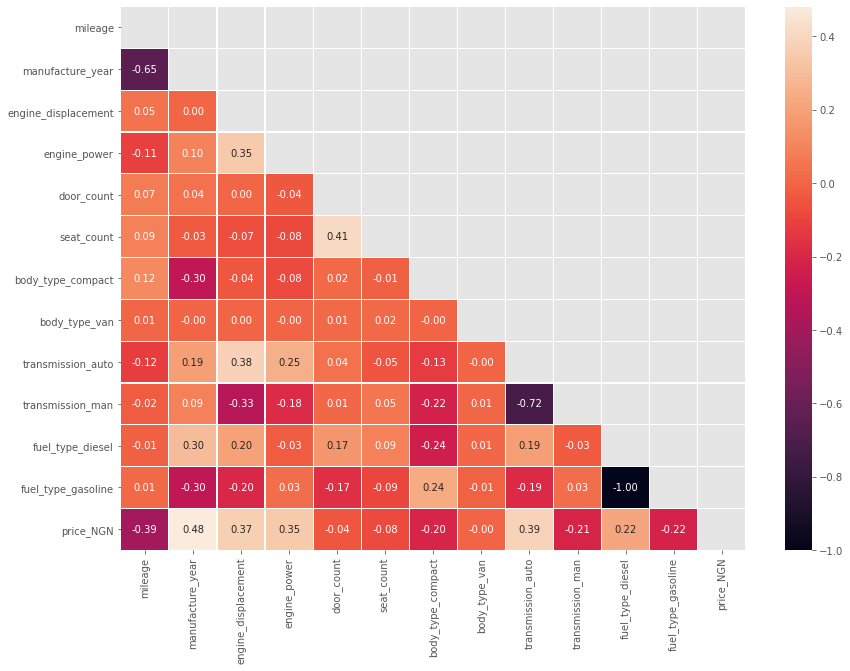

In [ ]:
corr = np.triu(cars45_df1.corr())
plt.figure(figsize = (14, 10))
sns.heatmap(cars45_df1.corr(), annot = True, linewidths = 0.2, fmt = '.2f', mask = corr)

The transmission_auto and transmission_man columns are highly negatively correlated (-0.72). So I'll drop the transmission_man column.

There's also the manufacture_year and mileage. I'll drop the manufacture year.

The Price columns holds high values and could rig the model performance. So log transformation shall be applied to normalise the values. 

In [ ]:
cars45_num = cars45_num.drop(columns = ['transmission_man', 'manufacture_year'])

In [ ]:
cars45_num.head()

,mileage,engine_displacement,engine_power,door_count,seat_count,body_type_compact,body_type_van,transmission_auto,fuel_type_diesel,fuel_type_gasoline,price_NGN
0,164500,2600,110,4,5,1,0,1,0,1,873428
1,134751,2150,103,3,5,1,0,0,0,1,666174
2,134751,2150,103,3,5,1,0,0,0,1,666174
3,134751,2150,103,3,5,1,0,0,0,1,666174
4,164500,2150,103,4,5,1,0,1,0,1,843820


The values of the price variable are really large and will affect the absolute numbers of the regression model. To manage this, the price data is normalises using log.

In [ ]:
Y = np.log(cars45_num['price_NGN']).values
X = cars45_num.drop(columns = ['price_NGN']).values

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 10)

The differing scales of the raw data may impact these algorithms. Part of a requirement for a standardised data set is to have each attribute have a mean value of zero and a standard deviation of 1. I shall implement standardisation using pipelines and then use cross-validation to validate performance of all the algorithms.

In [ ]:
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()), ('LR', LinearRegression())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()), ('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()), ('RF', RandomForestRegressor())])))
pipelines.append(('ScaledGB', Pipeline([('Scaler', StandardScaler()), ('GB', GradientBoostingRegressor())])))

results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits = 3, random_state = 10)
    cv_results = cross_val_score(model, X_train, Y_train, cv = kfold, scoring = 'neg_mean_squared_error')
    results.append(cv_results)
    names.append(name)
    notification = '%s: %f (%f)' % (name, cv_results.mean(), cv_results.std())
    print(notification)

ScaledLR: -0.438976 (0.001259)
ScaledKNN: -0.216174 (0.000748)
ScaledRF: -0.142303 (0.000926)
ScaledGB: -0.326531 (0.001381)


From the output above, it looks like the Random Forest Regressor performs the best using a scaled version of the data. From this point onward, I will build the regression algorithm using the Random Forest Regressor.

In [ ]:
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
param_grid = {'max_depth': np.array([5, 10, 15, 20, 25]), 
              'n_estimators': np.array([200, 200, 600, 800, 1000])}
model = RandomForestRegressor(random_state = 10)
kfold = KFold(n_splits = 3, random_state = 10)
grid = GridSearchCV(estimator = model, param_grid = param_grid, scoring = 'neg_mean_squared_error', cv = kfold)
grid_result = grid.fit(X_train_scaled, Y_train)

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('%f (%f) with: %r' % (mean, stdev, param))

print('Best: %f using %s' % (grid_result.best_score_, grid_result.best_params_))

The best max_depth configuration is 10 with the negative mean square error closest to 0.



#### Finalise and validate model


In [ ]:
model = RandomForestRegressor(random_state = 10, max_depth = 10)
model.fit(X_train_scaled, Y_train)

X_test_rescaled = scaler.transform(X_test)
predictions = model.predict(X_test_rescaled)
mse = mean_squared_error(Y_test, predictions, squared = True)
rmse = mean_squared_error(Y_test, predictions, squared = False)
mse, rmse

From the mean square error of 0.27294 between the prediction outputs vs the test data, the Random Forest performed well. Important to note that the mean_square_error is calculated using the scaled data. It does not represent the error between the actual car prices and predicted prices. To better appreciate the outcome of the predictions, I look at the raw predicted values and the corresponding test data.

In [ ]:
predictions

In [ ]:
compare_data = pd.DataFrame({'Prediction': predictions, 'Test Data' : Y_test})
compare_data.head(10)

From the data frame output above, the difference between the predicted value and test data is pretty small. Take note that the data is scaled and log normalised. So, I have to inverse transform these data to see the actual values. To do that, I apply the  exp function to the **Prediction** column

In [ ]:
#index = [i for i in range(len(predictions))]

In [ ]:
Y_test_actual = np.exp(Y_test)
Y_test_predicted = np.exp(predictions)

diff = abs(Y_test_actual - Y_test_predicted)

predicted_actual = pd.DataFrame({'Test Data': Y_test_actual, 'Predicted Price': Y_test_predicted, 'Difference': diff})
predicted_actual = predicted_actual.astype(int)
predicted_actual.head(10)

# **The End!**

Seghe Momodu